In [1]:
from __future__ import division
import tensorflow as tf
from tensorflow.contrib.rnn import GRUCell, MultiRNNCell,BasicLSTMCell
import os
from utils import shape
import numpy as np
import shutil
#from config import TrainConfig
import matplotlib.pyplot as plt
import librosa.display
import random
from os import walk
import math
# -*- coding: utf-8 -*-
#!/usr/bin/env python

import tensorflow as tf
from utils import closest_power_of_two

# TODO tf arg
# Model
class ModelConfig:
    SR = 16000                # Sample Rate
    L_FRAME = 1024            # default 1024
    L_HOP = closest_power_of_two(L_FRAME / 4)
    SEQ_LEN = 4
    # For Melspectogram
    N_MELS = 512
    F_MIN = 0.0

# Train
class TrainConfig:
    CASE = str(ModelConfig.SEQ_LEN) + 'frames_ikala'
    CKPT_PATH = 'checkpoints/' + CASE
    GRAPH_PATH = 'graphs/' + CASE + '/train'
    DATA_PATH = 'dataset/train/ikala'
    DATA_PATH2 = 'dataset/test/ikala'
    LR = 0.0001
    FINAL_STEP = 10000#00#00
    CKPT_STEP = 50#0
    NUM_WAVFILE = 1
    SECONDS = 8.192 # To get 512,512 in melspecto
    RE_TRAIN = True
    session_conf = tf.ConfigProto(
        device_count={'CPU': 1, 'GPU': 1},
        gpu_options=tf.GPUOptions(
            allow_growth=True,
            per_process_gpu_memory_fraction=0.25
        ),
    )
#Test
# Train
    
    
#haha = np.loadtxt(open('errorrate.csv',"rb"),delimiter=",",skiprows=0)[0,:]
#plt.plot(haha)

In [2]:
#preprocess
def get_random_wav(filenames, sec, sr=ModelConfig.SR):
    # load wav -> pad if necessary to fit sr*sec -> get random samples with len = sr*sec -> map = do this for all in filenames -> put in np.array
    src1_src2 = np.array(list(map(lambda f: _sample_range(_pad_wav(librosa.load(f, sr=sr, mono=False)[0], sr, sec), sr, sec), filenames)))
    mixed = np.array(list(map(lambda f: librosa.to_mono(f), src1_src2)))
    src1, src2 = src1_src2[:, 0], src1_src2[:, 1]
    return mixed, src1, src2

# Batch considered
def to_spectrogram(wav, len_frame=ModelConfig.L_FRAME, len_hop=ModelConfig.L_HOP):
    return np.array(list(map(lambda w: librosa.stft(w, n_fft=len_frame, hop_length=len_hop), wav)))
    #逆变换：istft(stft_matrixes)
# Batch considered
def to_wav(mag, phase, len_hop=ModelConfig.L_HOP):
    stft_matrix = get_stft_matrix(mag, phase)
    return np.array(list(map(lambda s: librosa.istft(s, hop_length=len_hop), stft_matrix)))

# Batch considered
def to_wav_from_spec(stft_maxrix, len_hop=ModelConfig.L_HOP):
    return np.array(list(map(lambda s: librosa.istft(s, hop_length=len_hop), stft_maxrix)))

# Batch considered
def to_wav_mag_only(mag, init_phase, len_frame=ModelConfig.L_FRAME, len_hop=ModelConfig.L_HOP, num_iters=50):
    #return np.array(list(map(lambda m_p: griffin_lim(m, len_frame, len_hop, num_iters=num_iters, phase_angle=p)[0], list(zip(mag, init_phase))[1])))
    return np.array(list(map(lambda m: lambda p: griffin_lim(m, len_frame, len_hop, num_iters=num_iters, phase_angle=p), list(zip(mag, init_phase))[1])))

# Batch considered
def get_magnitude(stft_matrixes):
    return np.abs(stft_matrixes)

# Batch considered
def get_phase(stft_maxtrixes):
    return np.angle(stft_maxtrixes)

# Batch considered
def get_stft_matrix(magnitudes, phases):
    return magnitudes * np.exp(1.j * phases)

# Batch considered
def soft_time_freq_mask(target_src, remaining_src):
    mask = np.abs(target_src) / (np.abs(target_src) + np.abs(remaining_src) + np.finfo(float).eps)
    return mask

# Batch considered
def hard_time_freq_mask(target_src, remaining_src):
    mask = np.where(target_src > remaining_src, 1., 0.)
    return mask

def write_wav(data, path, sr=ModelConfig.SR, format='wav', subtype='PCM_16'):
    sf.write('{}.wav'.format(path), data, sr, format=format, subtype=subtype)

def griffin_lim(mag, len_frame, len_hop, num_iters, phase_angle=None, length=None):
    assert(num_iters > 0)
    if phase_angle is None:
        phase_angle = np.pi * np.random.rand(*mag.shape)
    spec = get_stft_matrix(mag, phase_angle)
    for i in range(num_iters):
        wav = librosa.istft(spec, win_length=len_frame, hop_length=len_hop, length=length)
        if i != num_iters - 1:
            spec = librosa.stft(wav, n_fft=len_frame, win_length=len_frame, hop_length=len_hop)
            _, phase = librosa.magphase(spec)
            phase_angle = np.angle(phase)
            spec = get_stft_matrix(mag, phase_angle)
    return wav

def _pad_wav(wav, sr, duration):
    assert(wav.ndim <= 2)

    n_samples = int(sr * duration)
    pad_len = np.maximum(0, n_samples - wav.shape[-1])
    if wav.ndim == 1:
        pad_width = (0, pad_len)
    else:
        pad_width = ((0, 0), (0, pad_len))
    wav = np.pad(wav, pad_width=pad_width, mode='constant', constant_values=0)

    return wav

def _sample_range(wav, sr, duration):
    assert(wav.ndim <= 2)

    target_len = int(sr * duration)
    wav_len = wav.shape[-1]
    start = np.random.choice(range(np.maximum(1, wav_len - target_len)), 1)[0]
    end = start + target_len
    if wav.ndim == 1:
        wav = wav[start:end]
    else:
        wav = wav[:, start:end]
    return wav
def bss_eval_sources(reference_sources, estimated_sources,
                     compute_permutation=True):

    # make sure the input is of shape (nsrc, nsampl)
    if estimated_sources.ndim == 1:
        estimated_sources = estimated_sources[np.newaxis, :]
        print("estimated_sources.ndim == 1")
    if reference_sources.ndim == 1:
        reference_sources = reference_sources[np.newaxis, :]
        print("reference_sources.ndim == 1")

    validate(reference_sources, estimated_sources)
    # If empty matrices were supplied, return empty lists (special case)
    if reference_sources.size == 0 or estimated_sources.size == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])

    nsrc = estimated_sources.shape[0]

    # does user desire permutations?
    if compute_permutation:
        # compute criteria for all possible pair matches
        sdr = np.empty((nsrc, nsrc))
        sir = np.empty((nsrc, nsrc))
        sar = np.empty((nsrc, nsrc))
        for jest in range(nsrc):
            for jtrue in range(nsrc):
                s_true, e_spat, e_interf, e_artif = \
                    _bss_decomp_mtifilt(reference_sources,
                                        estimated_sources[jest],
                                        jtrue, 512)
                sdr[jest, jtrue], sir[jest, jtrue], sar[jest, jtrue] = \
                    _bss_source_crit(s_true, e_spat, e_interf, e_artif)

        # select the best ordering
        perms = list(itertools.permutations(list(range(nsrc))))
        mean_sir = np.empty(len(perms))
        dum = np.arange(nsrc)
        for (i, perm) in enumerate(perms):
            mean_sir[i] = np.mean(sir[perm, dum])
        popt = perms[np.argmax(mean_sir)]
        idx = (popt, dum)
        return (sdr[idx], sir[idx], sar[idx], np.asarray(popt))
    else:
        # compute criteria for only the simple correspondence
        # (estimate 1 is estimate corresponding to reference source 1, etc.)
        sdr = np.empty(nsrc)
        sir = np.empty(nsrc)
        sar = np.empty(nsrc)
        for j in range(nsrc):
            s_true, e_spat, e_interf, e_artif = \
                _bss_decomp_mtifilt(reference_sources,
                                    estimated_sources[j],
                                    j, 512)
            sdr[j], sir[j], sar[j] = \
                _bss_source_crit(s_true, e_spat, e_interf, e_artif)

        # return the default permutation for compatibility
        popt = np.arange(nsrc)
        return (sdr, sir, sar, popt)
#preprocess
def get_random_wav(filenames, sec, sr=22050):
    # load wav -> pad if necessary to fit sr*sec -> get random samples with len = sr*sec -> map = do this for all in filenames -> put in np.array
    src1_src2 = np.array(list(map(lambda f: _sample_range(_pad_wav(librosa.load(f, sr=sr, mono=False)[0], sr, sec), sr, sec), filenames)))
    mixed = np.array(list(map(lambda f: librosa.to_mono(f), src1_src2)))   #用librosa转换成单一
    src1, src2 = src1_src2[:, 0], src1_src2[:, 1]
    return mixed, src1, src2
wavfiles = []
for (root, dirs, files) in walk('dataset/train/ikala'):
    wavfiles.extend(['{}/{}'.format(root, f) for f in files if f.endswith(".wav")])
    wavfiles = random.sample(wavfiles, 1)
    print(wavfiles);
    mixed, src1, src2 = get_random_wav(wavfiles, 8.192, ModelConfig.SR)
mixed = np.squeeze(mixed)
print(type(mixed));
print(mixed.T.shape)
print(mixed.T.reshape(mixed.T.shape))


def bss_eval_global(mixed_wav, src1_wav, src2_wav, pred_src1_wav, pred_src2_wav):
    len_cropped = pred_src1_wav.shape[-1]
    src1_wav = src1_wav[:, :len_cropped]
    src2_wav = src2_wav[:, :len_cropped]
    mixed_wav = mixed_wav[:, :len_cropped]
    gnsdr = gsir = gsar = np.zeros(2)
    total_len = 0
    for i in range(1,1):
        sdr, sir, sar, _ = bss_eval_sources(np.array([src1_wav[i], src2_wav[i]]),
                                            np.array([pred_src1_wav[i], pred_src2_wav[i]]), False)
        sdr_mixed, _, _, _ = bss_eval_sources(np.array([src1_wav[i], src2_wav[i]]),
                                              np.array([mixed_wav[i], mixed_wav[i]]), False)
        nsdr = sdr - sdr_mixed
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        total_len += len_cropped
    gnsdr = gnsdr / total_len
    gsir = gsir / total_len
    gsar = gsar / total_len
    return gnsdr, gsir, gsar

def to_spectrogram(wav, len_frame=1024, len_hop=closest_power_of_two(1024/4)):
    return np.array(list(map(lambda w: librosa.stft(w, n_fft=len_frame, hop_length=len_hop), wav)))
print(closest_power_of_two(1024/4));

['dataset/train/ikala/tammy_1_07.wav']
<class 'numpy.ndarray'>
(131072,)
[0.03804016 0.09942627 0.02682495 ... 0.         0.         0.        ]
256


In [3]:

class Model:
    def __init__(self, n_rnn_layer=3, hidden_size=256):
        print('Model initializing')
        print(ModelConfig.L_FRAME // 2 + 1);
        # Input, Output
        self.x_mixed = tf.placeholder(tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name='x_mixed')
        self.y_src1 = tf.placeholder(tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name='y_src1')
        self.y_src2 = tf.placeholder(tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name='y_src2')

        # 隐藏层神经元
        self.hidden_size = hidden_size
        #几层神经网络
        self.n_layer = n_rnn_layer
        self.net = tf.make_template('net', self._net)
        self()

    def __call__(self):
        return self.net()
    

    def _net(self):
        # RNN and dense layers
        rnn_layer = BasicLSTMCell([GRUCell(self.hidden_size) for _ in range(self.n_layer)])
        output_rnn, rnn_state = tf.nn.dynamic_rnn(rnn_layer, self.x_mixed, dtype=tf.float32)
        input_size = shape(self.x_mixed)[2]
        y_hat_src1 = tf.layers.dense(inputs=output_rnn, units=input_size, activation=tf.nn.relu, name='y_hat_src1')
        y_hat_src2 = tf.layers.dense(inputs=output_rnn, units=input_size, activation=tf.nn.relu, name='y_hat_src2')

        # time-freq masking layer
        y_tilde_src1 = y_hat_src1 / (y_hat_src1 + y_hat_src2 + np.finfo(float).eps) * self.x_mixed
        y_tilde_src2 = y_hat_src2 / (y_hat_src1 + y_hat_src2 + np.finfo(float).eps) * self.x_mixed

        return y_tilde_src1, y_tilde_src2

    def loss(self):
        pred_y_src1, pred_y_src2 = self()
        return tf.square(self.y_src1 - pred_y_src1) + tf.square(self.y_src2 - pred_y_src2) # tf.reduce_mean(, name='loss')

    @staticmethod
    # shape = (batch_size, n_freq, n_frames) => (batch_size, n_frames, n_freq)
    def spec_to_batch(src):
        num_wavs, freq, n_frames = src.shape

        # Padding
        pad_len = 0
        if n_frames % ModelConfig.SEQ_LEN > 0:
            pad_len = (ModelConfig.SEQ_LEN - (n_frames % ModelConfig.SEQ_LEN))
        pad_width = ((0, 0), (0, 0), (0, pad_len))
        padded_src = np.pad(src, pad_width=pad_width, mode='constant', constant_values=0)

        assert(padded_src.shape[-1] % ModelConfig.SEQ_LEN == 0)

        batch = np.reshape(padded_src.transpose(0, 2, 1), (-1, ModelConfig.SEQ_LEN, freq))#-1是让函数自己计算
        return batch, padded_src

    @staticmethod
    def batch_to_spec(src, num_wav):
        # shape = (batch_size, n_frames, n_freq) => (batch_size, n_freq, n_frames)
        batch_size, seq_len, freq = src.shape
        src = np.reshape(src, (num_wav, -1, freq))
        src = src.transpose(0, 2, 1)
        return src

    @staticmethod
    def load_state(sess, ckpt_path):
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(ckpt_path + '/checkpoint'))
        if ckpt and ckpt.model_checkpoint_path:
            tf.train.Saver().restore(sess, ckpt.model_checkpoint_path)

In [4]:
# -*- coding: utf-8 -*-
# !/usr/bin/env python
'''
By Dabi Ahn. andabi412@gmail.com.
https://www.github.com/andabi
'''



class Data:
    def __init__(self, path):
        self.path = path

    def next_wavs(self, sec, size=1):
        wavfiles = []
        for (root, dirs, files) in walk(self.path):
            wavfiles.extend(['{}/{}'.format(root, f) for f in files if f.endswith(".wav")])
        wavfiles = random.sample(wavfiles, size)
        mixed, src1, src2 = get_random_wav(wavfiles, sec, ModelConfig.SR)
        return mixed, src1, src2, wavfiles

class Data:
    def __init__(self, path):
        self.path = path

    def next_wavs(self, sec, size=1):
        wavfiles = []
        for (root, dirs, files) in walk(self.path):
            wavfiles.extend(['{}/{}'.format(root, f) for f in files if f.endswith(".wav")])
        wavfiles = random.sample(wavfiles, size)
        mixed, src1, src2 = get_random_wav(wavfiles, sec, ModelConfig.SR)
        return mixed, src1, src2, wavfiles
    
def get_random_wav(filenames, sec, sr=ModelConfig.SR):
    # load wav -> pad if necessary to fit sr*sec -> get random samples with len = sr*sec -> map = do this for all in filenames -> put in np.array
    src1_src2 = np.array(list(map(lambda f: _sample_range(_pad_wav(librosa.load(f, sr=sr, mono=False)[0], sr, sec), sr, sec), filenames)))
    print('loaded wave');
    print(src1_src2.shape)
    mixed = np.array(list(map(lambda f: librosa.to_mono(f), src1_src2)))
    src1, src2 = src1_src2[:, 0], src1_src2[:, 1]
    return mixed, src1, src2

class Diff(object):
    def __init__(self, v=0.):
        self.value = v
        self.diff = 0.

    def update(self, v):
        if self.value:
            diff = (v / self.value - 1)
            self.diff = diff
        self.value = v


In [ ]:
import tensorflow as tf
#from model import Model
from model import Model
import os
import shutil
from data import Data
from preprocess import to_spectrogram, get_magnitude

import librosa.display


def summaries(model, loss):
    for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        print(v);
        print(loss);
        tf.summary.histogram(v.name, v)
        tf.summary.histogram('grad/' + v.name, tf.gradients(loss, v))
    tf.summary.scalar('loss', loss)
    tf.summary.histogram('x_mixed', model.x_mixed)
    tf.summary.histogram('y_src1', model.y_src1)
    tf.summary.histogram('y_src2', model.y_src1)
    return tf.summary.merge_all()

# TODO multi-gpu
def train(errorrate):
    # Model
    model = Model()
    result = [];
    # Loss, Optimizer
    global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    loss_fn = model.loss()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=TrainConfig.LR).minimize(loss_fn, global_step=global_step)#
    # Summaries
    summary_op = summaries(model, loss_fn)
    recorder = model._net();
    
    with tf.Session(config=TrainConfig.session_conf) as sess:

        # Initialized, Load state
        sess.run(tf.global_variables_initializer())
        model.load_state(sess, TrainConfig.CKPT_PATH)

        writer = tf.summary.FileWriter(TrainConfig.GRAPH_PATH, sess.graph)

        # Input source
        data = Data(TrainConfig.DATA_PATH)

        loss = Diff()
        for step in range(global_step.eval(), TrainConfig.FINAL_STEP): # changed xrange to range for py3
            mixed_wav, src1_wav, src2_wav, _ = data.next_wavs(TrainConfig.SECONDS, 10)

            mixed_spec = to_spectrogram(mixed_wav)   #先变成光谱
            mixed_mag = get_magnitude(mixed_spec)    #得到幅度

            src1_spec, src2_spec = to_spectrogram(src1_wav), to_spectrogram(src2_wav)
            src1_mag, src2_mag = get_magnitude(src1_spec), get_magnitude(src2_spec)

            src1_batch, _ = model.spec_to_batch(src1_mag)
            src2_batch, _ = model.spec_to_batch(src2_mag)
            mixed_batch, _ = model.spec_to_batch(mixed_mag)
            
            src1_batch = src1_batch;
            src2_batch = src2_batch
            mixed_batch = mixed_batch

            l, haha, summary,result1 = sess.run([loss_fn, optimizer, summary_op,recorder],
                                     feed_dict={model.x_mixed: mixed_batch, model.y_src1: src1_batch,
                                                model.y_src2: src2_batch})

            loss.update(l)
            print('step-{}\td_loss={:2.2f}\tloss={}'.format(step, loss.diff * 100, loss.value))
            #writer.add_summary(summary, global_step=step)

            # Save state
            if step % TrainConfig.CKPT_STEP == 0:
                tf.train.Saver().save(sess, TrainConfig.CKPT_PATH + '/checkpoint', global_step=step)
            #xphase = get_phase(mixed_spec);
            #seq_len = xphase.shape[-1]
            #ohno = model.batch_to_spec(result1[1], 1)[:, :, :seq_len]
            #pred_result = to_wav_from_spec(ohno)#,xphase);
            #pred_result = np.squeeze(pred_result);
            #librosa.output.write_wav('training.wav', pred_result, 16000)
            errorrate[0,step] = l#math.sqrt(abs(l/mean(sum(sum(result1[1]))+sum(sum(result1[0])))));
            print(errorrate[0,step])
            
            #test part
        data = Data(TrainConfig.DATA_PATH2)
        mixed_wav2, src1_wav2, src2_wav2, wavfiles2 = data.next_wavs(TrainConfig.SECONDS, 1)
        mixed_spec2, src1_spec2, src2_spec2 = to_spectrogram(mixed_wav2),to_spectrogram(src1_wav2), to_spectrogram(src2_wav2)
        mixed_mag2, src1_mag2, src2_mag2 = get_magnitude(mixed_spec2),get_magnitude(src1_spec2), get_magnitude(src2_spec2)
        xphase2 = get_phase(mixed_spec2);
        
        
        
        src1_batch2, _ = model.spec_to_batch(src1_mag2)
        print("src1_batch2:")
        print(src1_batch2.shape)
        src2_batch2, _ = model.spec_to_batch(src2_mag2)
        mixed_batch2, _ = model.spec_to_batch(mixed_mag2)
        
        src1_batch2 = src1_batch2
        src2_batch2 = src2_batch2
        mixed_batch2 = mixed_batch2

        l2,result12 = sess.run([loss_fn,recorder], feed_dict={model.x_mixed: mixed_batch2, model.y_src1: src1_batch2,
                                                model.y_src2: src2_batch2})

        seq_len2 = xphase2.shape[-1]
        print(result12[0].shape);
        print(result12[1].shape);
        result1part1 = result12[0]
        result1part2 = result12[1]
        print('src1_wav2')

        print(type(src1_wav2[0]))
        src1_wav2 = src1_wav2[0];
        src1_wav2 = src1_wav2[np.newaxis, :]
        src2_wav2 = src2_wav2[0]
        src2_wav2 = src2_wav2[np.newaxis, :]
        print("src1_wav2")
        print(src1_wav2.shape)
        print(min(src1_wav2.T))
        print(max(src1_wav2.T))
        print(np.mean(src1_wav2))
        print("src2_wav2")
        print(src2_wav2.shape)
        print(min(src2_wav2.T))
        print(max(src2_wav2.T))
        print(np.mean(src2_wav2))
        result1part1 = model.batch_to_spec(result1part1, 1)[:, :, :seq_len2]
        result1part2 = model.batch_to_spec(result1part2, 1)[:, :, :seq_len2]
        print("result1")
        print(result1part1.shape)
        print(min(result1part1))
        print(max(result1part1))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(result1part2))
        print(max(result1part2))
        print(np.mean(result1part2))
        #processing in time
        
        mask_src1 = soft_time_freq_mask(result1part1,result1part2)
        mask_src2 = 1.-mask_src1;
        
        result1part1 = mixed_mag2*mask_src1;
        result1part2 = mixed_mag2*mask_src2;
        
        
        pred_result2 = to_wav_from_spec(result1part2)#,xphase);
        
        
        #process the wav to detect GDMRN
        
        mixed_phase = get_phase(mixed_spec2)
        pred_src1_wav = to_wav(result1part1,mixed_phase)
        result1part1 = pred_src1_wav
        pred_src2_wav = to_wav(result1part2,mixed_phase)
        result1part2 = pred_src2_wav
        mixed_wav = mixed_wav2;
        src1_wav = src1_wav2;
        src2_wav = src2_wav2;
            
        print("result1")
        print(result1part1.shape)
        print(min(abs(result1part1.T)))
        print(max(result1part1.T))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(abs(result1part2.T)))
        print(max(result1part2.T))
        print(np.mean(result1part2))
         
            
        for i in range(0,131072):
            if src1_wav[0,i] ==0:
                src1_wav[0,i] = src1_wav[0,i]+0.01
            if src2_wav[0,i] ==0:
                src2_wav[0,i] = src2_wav[0,i]+0.01
            if pred_src1_wav[0,i] ==0:
                pred_src1_wav[0,i] = pred_src1_wav[0,i]+0.01
            if pred_src2_wav[0,i] ==0:
                pred_src2_wav[0,i] = pred_src2_wav[0,i]+0.01
       
        
        #存成文件
        john = np.savetxt('errorrate.csv', errorrate.T, delimiter = ',')
        print(errorrate.shape)
        print(errorrate[0])
        plt.figure()
        plt.plot(errorrate[0])
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_predicted.wav', pred_src1_wav.T, 16000)
        plt.figure()
        print('predicted accompany:')
        plt.plot( pred_src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_predicted2.wav', pred_src2_wav.T, 16000)
        plt.figure()
        print('predicted vocal:')
        plt.plot(pred_src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_original1.wav',src1_wav.T, 16000)
        plt.figure()
        print('original accompany:')
        plt.plot( src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_original2.wav',src2_wav.T, 16000)
        plt.figure()
        print('original vocal:')
        plt.plot(src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        difference = src2_wav-pred_src2_wav;
        print(difference.shape)
        john = librosa.output.write_wav('lstm_difference.wav',difference.T, 16000)
        plt.figure()
        print('Difference:')
        plt.plot(difference.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        print(np.mean(difference)/np.mean(src2_wav))
        


        
        writer.close()

def setup_path():
    if TrainConfig.RE_TRAIN:
        if os.path.exists(TrainConfig.CKPT_PATH):
            shutil.rmtree(TrainConfig.CKPT_PATH)
        if os.path.exists(TrainConfig.GRAPH_PATH):
            shutil.rmtree(TrainConfig.GRAPH_PATH)
    if not os.path.exists(TrainConfig.CKPT_PATH):
        os.makedirs(TrainConfig.CKPT_PATH)


if __name__ == '__main__':
    errorrate = np.zeros([2,TrainConfig.FINAL_STEP]);
    setup_path()
    train(errorrate)


<tf.Variable 'net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0' shape=(769, 512) dtype=float32_ref>
Tensor("loss:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0 is illegal; using net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel_0 instead.
INFO:tensorflow:Summary name grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0 is illegal; using grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel_0 instead.
<tf.Variable 'net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
Tensor("loss:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias:0 is illegal; using net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias_0 instead.
INFO:tensorflow:Summary name grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias:0 is illegal; using grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias_0 instead.
<tf.Variable 'net/rnn/multi_rnn_cell/cell_0/

step-17	d_loss=-46.88	loss=5.7491936683654785
5.7491936683654785
step-18	d_loss=35.77	loss=7.805695533752441
7.805695533752441
step-19	d_loss=-9.27	loss=7.0823163986206055
7.0823163986206055
step-20	d_loss=14.96	loss=8.141702651977539
8.141702651977539
step-21	d_loss=8.10	loss=8.801034927368164
8.801034927368164
step-22	d_loss=11.62	loss=9.823981285095215
9.823981285095215
step-23	d_loss=-15.93	loss=8.259197235107422
8.259197235107422
step-24	d_loss=-0.70	loss=8.201773643493652
8.201773643493652
step-25	d_loss=17.95	loss=9.673901557922363
9.673901557922363
step-26	d_loss=-31.26	loss=6.650221347808838
6.650221347808838
step-27	d_loss=12.96	loss=7.512330532073975
7.512330532073975
step-28	d_loss=11.08	loss=8.344614028930664
8.344614028930664
step-29	d_loss=0.15	loss=8.356758117675781
8.356758117675781
step-30	d_loss=-9.36	loss=7.574221611022949
7.574221611022949
step-31	d_loss=6.54	loss=8.069758415222168
8.069758415222168
step-32	d_loss=-0.53	loss=8.026665687561035
8.026665687561035
step

step-149	d_loss=15.77	loss=8.606721878051758
8.606721878051758
step-150	d_loss=-5.81	loss=8.106642723083496
8.106642723083496
step-151	d_loss=-2.35	loss=7.916478633880615
7.916478633880615
step-152	d_loss=-1.58	loss=7.791355609893799
7.791355609893799
step-153	d_loss=-11.16	loss=6.921721935272217
6.921721935272217
step-154	d_loss=-1.22	loss=6.837211608886719
6.837211608886719
step-155	d_loss=8.69	loss=7.431057453155518
7.431057453155518
step-156	d_loss=7.02	loss=7.952669143676758
7.952669143676758
step-157	d_loss=2.68	loss=8.165898323059082
8.165898323059082
step-158	d_loss=-5.29	loss=7.733606815338135
7.733606815338135
step-159	d_loss=-0.90	loss=7.664331912994385
7.664331912994385
step-160	d_loss=-0.24	loss=7.64568567276001
7.64568567276001
step-161	d_loss=6.26	loss=8.124369621276855
8.124369621276855
step-162	d_loss=-20.18	loss=6.485105037689209
6.485105037689209
step-163	d_loss=31.05	loss=8.498998641967773
8.498998641967773
step-164	d_loss=-18.70	loss=6.909345626831055
6.90934562683

step-279	d_loss=-9.99	loss=5.903875827789307
5.903875827789307
step-280	d_loss=18.49	loss=6.995483875274658
6.995483875274658
step-281	d_loss=-0.58	loss=6.954777240753174
6.954777240753174
step-282	d_loss=-9.52	loss=6.292505741119385
6.292505741119385
step-283	d_loss=10.09	loss=6.927160263061523
6.927160263061523
step-284	d_loss=-14.03	loss=5.95502233505249
5.95502233505249
step-285	d_loss=9.04	loss=6.493516445159912
6.493516445159912
step-286	d_loss=3.01	loss=6.688652992248535
6.688652992248535
step-287	d_loss=-12.16	loss=5.875089645385742
5.875089645385742
step-288	d_loss=-4.43	loss=5.614736080169678
5.614736080169678
step-289	d_loss=26.44	loss=7.099084377288818
7.099084377288818
step-290	d_loss=2.70	loss=7.290972709655762
7.290972709655762
step-291	d_loss=7.08	loss=7.806948184967041
7.806948184967041
step-292	d_loss=-23.04	loss=6.008481025695801
6.008481025695801
step-293	d_loss=10.67	loss=6.649293422698975
6.649293422698975
step-294	d_loss=10.80	loss=7.367380142211914
7.36738014221

step-410	d_loss=-16.10	loss=6.652050018310547
6.652050018310547
step-411	d_loss=7.34	loss=7.140317440032959
7.140317440032959
step-412	d_loss=0.12	loss=7.149209022521973
7.149209022521973
step-413	d_loss=-2.76	loss=6.951686382293701
6.951686382293701
step-414	d_loss=-14.06	loss=5.974365234375
5.974365234375
step-415	d_loss=14.67	loss=6.85062313079834
6.85062313079834
step-416	d_loss=-19.11	loss=5.541805267333984
5.541805267333984
step-417	d_loss=24.64	loss=6.907129287719727
6.907129287719727
step-418	d_loss=1.34	loss=6.99960994720459
6.99960994720459
step-419	d_loss=-13.16	loss=6.07846212387085
6.07846212387085
step-420	d_loss=8.06	loss=6.568084239959717
6.568084239959717
step-421	d_loss=4.87	loss=6.888233184814453
6.888233184814453
step-422	d_loss=-18.69	loss=5.6011433601379395
5.6011433601379395
step-423	d_loss=25.40	loss=7.023669719696045
7.023669719696045
step-424	d_loss=-22.20	loss=5.464653968811035
5.464653968811035
step-425	d_loss=9.43	loss=5.979979515075684
5.979979515075684
st

step-541	d_loss=-21.55	loss=5.59492301940918
5.59492301940918
step-542	d_loss=-2.17	loss=5.4734697341918945
5.4734697341918945
step-543	d_loss=13.34	loss=6.203799724578857
6.203799724578857
step-544	d_loss=12.31	loss=6.96743106842041
6.96743106842041
step-545	d_loss=-2.01	loss=6.827160358428955
6.827160358428955
step-546	d_loss=-9.72	loss=6.163523197174072
6.163523197174072
step-547	d_loss=-9.84	loss=5.556981086730957
5.556981086730957
step-548	d_loss=30.17	loss=7.233292579650879
7.233292579650879
step-549	d_loss=-11.14	loss=6.427281379699707
6.427281379699707
step-550	d_loss=-30.20	loss=4.486171722412109
4.486171722412109
step-551	d_loss=70.94	loss=7.668605327606201
7.668605327606201
step-552	d_loss=-11.16	loss=6.813021659851074
6.813021659851074
step-553	d_loss=17.47	loss=8.003437995910645
8.003437995910645
step-554	d_loss=-14.58	loss=6.836337566375732
6.836337566375732
step-555	d_loss=-1.80	loss=6.713165283203125
6.713165283203125
step-556	d_loss=2.33	loss=6.869574069976807
6.869574

step-672	d_loss=0.75	loss=6.294961452484131
6.294961452484131
step-673	d_loss=-6.76	loss=5.869276523590088
5.869276523590088
step-674	d_loss=-3.05	loss=5.6901068687438965
5.6901068687438965
step-675	d_loss=19.55	loss=6.802587985992432
6.802587985992432
step-676	d_loss=-14.10	loss=5.8437418937683105
5.8437418937683105
step-677	d_loss=1.15	loss=5.9108381271362305
5.9108381271362305
step-678	d_loss=26.88	loss=7.499570846557617
7.499570846557617
step-679	d_loss=-14.98	loss=6.375826835632324
6.375826835632324
step-680	d_loss=-10.93	loss=5.679190635681152
5.679190635681152
step-681	d_loss=17.52	loss=6.673951148986816
6.673951148986816
step-682	d_loss=1.15	loss=6.750572681427002
6.750572681427002
step-683	d_loss=0.69	loss=6.797036647796631
6.797036647796631
step-684	d_loss=-13.59	loss=5.873325347900391
5.873325347900391
step-685	d_loss=3.24	loss=6.063631534576416
6.063631534576416
step-686	d_loss=9.34	loss=6.630202293395996
6.630202293395996
step-687	d_loss=3.35	loss=6.852419376373291
6.85241

step-803	d_loss=-5.44	loss=6.326229095458984
6.326229095458984
step-804	d_loss=9.90	loss=6.952811241149902
6.952811241149902
step-805	d_loss=-14.53	loss=5.9428205490112305
5.9428205490112305
step-806	d_loss=5.21	loss=6.252207279205322
6.252207279205322
step-807	d_loss=5.12	loss=6.572042942047119
6.572042942047119
step-808	d_loss=-6.78	loss=6.126355171203613
6.126355171203613
step-809	d_loss=-4.58	loss=5.845512866973877
5.845512866973877
step-810	d_loss=10.26	loss=6.445516586303711
6.445516586303711
step-811	d_loss=13.44	loss=7.312032699584961
7.312032699584961
step-812	d_loss=-15.90	loss=6.149409770965576
6.149409770965576
step-813	d_loss=1.60	loss=6.2480573654174805
6.2480573654174805
step-814	d_loss=11.09	loss=6.940917015075684
6.940917015075684
step-815	d_loss=-6.96	loss=6.457690715789795
6.457690715789795
step-816	d_loss=4.10	loss=6.722564697265625
6.722564697265625
step-817	d_loss=-0.64	loss=6.679442405700684
6.679442405700684
step-818	d_loss=9.15	loss=7.290609836578369
7.29060983

step-933	d_loss=7.28	loss=7.274803161621094
7.274803161621094
step-934	d_loss=-14.58	loss=6.213963508605957
6.213963508605957
step-935	d_loss=-7.06	loss=5.775013446807861
5.775013446807861
step-936	d_loss=17.67	loss=6.795529365539551
6.795529365539551
step-937	d_loss=8.57	loss=7.377813339233398
7.377813339233398
step-938	d_loss=-6.64	loss=6.887839317321777
6.887839317321777
step-939	d_loss=-12.63	loss=6.018210411071777
6.018210411071777
step-940	d_loss=-9.25	loss=5.461272239685059
5.461272239685059
step-941	d_loss=16.86	loss=6.382057189941406
6.382057189941406
step-942	d_loss=-11.33	loss=5.659145355224609
5.659145355224609
step-943	d_loss=9.08	loss=6.173260688781738
6.173260688781738
step-944	d_loss=-3.48	loss=5.958593368530273
5.958593368530273
step-945	d_loss=15.18	loss=6.862968921661377
6.862968921661377
step-946	d_loss=8.10	loss=7.419000625610352
7.419000625610352
step-947	d_loss=-43.98	loss=4.156125068664551
4.156125068664551
step-948	d_loss=56.12	loss=6.488353729248047
6.48835372

step-1063	d_loss=2.86	loss=7.7443437576293945
7.7443437576293945
step-1064	d_loss=-26.89	loss=5.661953449249268
5.661953449249268
step-1065	d_loss=15.06	loss=6.514708995819092
6.514708995819092
step-1066	d_loss=-30.34	loss=4.53843355178833
4.53843355178833
step-1067	d_loss=36.36	loss=6.188484191894531
6.188484191894531
step-1068	d_loss=4.37	loss=6.459226131439209
6.459226131439209
step-1069	d_loss=-16.02	loss=5.42431640625
5.42431640625
step-1070	d_loss=5.23	loss=5.707737445831299
5.707737445831299
step-1071	d_loss=3.02	loss=5.879963397979736
5.879963397979736
step-1072	d_loss=-2.99	loss=5.704434394836426
5.704434394836426
step-1073	d_loss=5.19	loss=6.0002617835998535
6.0002617835998535
step-1074	d_loss=17.94	loss=7.0765509605407715
7.0765509605407715
step-1075	d_loss=-18.85	loss=5.742304801940918
5.742304801940918
step-1076	d_loss=-8.13	loss=5.2753167152404785
5.2753167152404785
step-1077	d_loss=25.32	loss=6.610876083374023
6.610876083374023
step-1078	d_loss=-3.59	loss=6.3735179901123

step-1191	d_loss=-1.25	loss=5.373358726501465
5.373358726501465
step-1192	d_loss=2.73	loss=5.519805431365967
5.519805431365967
step-1193	d_loss=13.29	loss=6.253261089324951
6.253261089324951
step-1194	d_loss=-7.97	loss=5.754781723022461
5.754781723022461
step-1195	d_loss=15.28	loss=6.634357929229736
6.634357929229736
step-1196	d_loss=-14.84	loss=5.64971923828125
5.64971923828125
step-1197	d_loss=15.19	loss=6.5076398849487305
6.5076398849487305
step-1198	d_loss=-17.96	loss=5.3390889167785645
5.3390889167785645
step-1199	d_loss=-3.73	loss=5.139949798583984
5.139949798583984
step-1200	d_loss=39.90	loss=7.190699100494385
7.190699100494385
step-1201	d_loss=-8.48	loss=6.580765247344971
6.580765247344971
step-1202	d_loss=-5.14	loss=6.242213726043701
6.242213726043701
step-1203	d_loss=-10.34	loss=5.597071647644043
5.597071647644043
step-1204	d_loss=5.65	loss=5.913300514221191
5.913300514221191
step-1205	d_loss=-10.37	loss=5.300294876098633
5.300294876098633
step-1206	d_loss=21.18	loss=6.422656

step-1320	d_loss=0.68	loss=6.860780715942383
6.860780715942383
step-1321	d_loss=2.29	loss=7.01814603805542
7.01814603805542
step-1322	d_loss=0.25	loss=7.035691261291504
7.035691261291504
step-1323	d_loss=-21.41	loss=5.529654026031494
5.529654026031494
step-1324	d_loss=-2.54	loss=5.389473915100098
5.389473915100098
step-1325	d_loss=32.90	loss=7.16287088394165
7.16287088394165
step-1326	d_loss=-10.92	loss=6.38042688369751
6.38042688369751
step-1327	d_loss=-6.70	loss=5.953139305114746
5.953139305114746
step-1328	d_loss=19.82	loss=7.133162498474121
7.133162498474121
step-1329	d_loss=-16.82	loss=5.933489799499512
5.933489799499512
step-1330	d_loss=10.58	loss=6.561264514923096
6.561264514923096
step-1331	d_loss=-4.82	loss=6.24474573135376
6.24474573135376
step-1332	d_loss=-8.87	loss=5.690564155578613
5.690564155578613
step-1333	d_loss=18.96	loss=6.7696404457092285
6.7696404457092285
step-1334	d_loss=1.24	loss=6.853728771209717
6.853728771209717
step-1335	d_loss=-17.74	loss=5.638042449951172


step-1449	d_loss=26.03	loss=7.1237921714782715
7.1237921714782715
step-1450	d_loss=-12.42	loss=6.23923397064209
6.23923397064209
step-1451	d_loss=-21.61	loss=4.890986442565918
4.890986442565918
step-1452	d_loss=22.73	loss=6.0029449462890625
6.0029449462890625
step-1453	d_loss=-10.11	loss=5.39608907699585
5.39608907699585
step-1454	d_loss=49.37	loss=8.06002426147461
8.06002426147461
step-1455	d_loss=-23.71	loss=6.148998737335205
6.148998737335205
step-1456	d_loss=14.24	loss=7.02475118637085
7.02475118637085
step-1457	d_loss=-26.54	loss=5.160308837890625
5.160308837890625
step-1458	d_loss=28.92	loss=6.652507781982422
6.652507781982422
step-1459	d_loss=1.83	loss=6.77451229095459
6.77451229095459
step-1460	d_loss=-13.81	loss=5.8392181396484375
5.8392181396484375
step-1461	d_loss=4.29	loss=6.089537620544434
6.089537620544434
step-1462	d_loss=-2.23	loss=5.953778266906738
5.953778266906738
step-1463	d_loss=-6.79	loss=5.549292087554932
5.549292087554932
step-1464	d_loss=12.85	loss=6.2621970176

step-1578	d_loss=3.17	loss=6.130799770355225
6.130799770355225
step-1579	d_loss=-24.18	loss=4.648284912109375
4.648284912109375
step-1580	d_loss=38.88	loss=6.455749034881592
6.455749034881592
step-1581	d_loss=-21.73	loss=5.053178310394287
5.053178310394287
step-1582	d_loss=3.71	loss=5.240408897399902
5.240408897399902
step-1583	d_loss=6.86	loss=5.600015640258789
5.600015640258789
step-1584	d_loss=-4.77	loss=5.332916259765625
5.332916259765625
step-1585	d_loss=-10.96	loss=4.748208045959473
4.748208045959473
step-1586	d_loss=34.69	loss=6.395310878753662
6.395310878753662
step-1587	d_loss=2.88	loss=6.579468727111816
6.579468727111816
step-1588	d_loss=-1.69	loss=6.468543529510498
6.468543529510498
step-1589	d_loss=-8.07	loss=5.946562767028809
5.946562767028809
step-1590	d_loss=-3.47	loss=5.740055561065674
5.740055561065674
step-1591	d_loss=-4.53	loss=5.479976654052734
5.479976654052734
step-1592	d_loss=-0.92	loss=5.429494380950928
5.429494380950928
step-1593	d_loss=9.09	loss=5.922887325286

step-1707	d_loss=10.84	loss=6.092202186584473
6.092202186584473
step-1708	d_loss=-6.12	loss=5.719165325164795
5.719165325164795
step-1709	d_loss=-9.42	loss=5.180600643157959
5.180600643157959
step-1710	d_loss=26.88	loss=6.57304048538208
6.57304048538208
step-1711	d_loss=-13.02	loss=5.717127323150635
5.717127323150635
step-1712	d_loss=-6.96	loss=5.319077491760254
5.319077491760254
step-1713	d_loss=7.61	loss=5.723912239074707
5.723912239074707
step-1714	d_loss=-0.84	loss=5.676061153411865
5.676061153411865
step-1715	d_loss=13.30	loss=6.4307661056518555
6.4307661056518555
step-1716	d_loss=-3.99	loss=6.174145698547363
6.174145698547363
step-1717	d_loss=-16.99	loss=5.1248698234558105
5.1248698234558105
step-1718	d_loss=34.53	loss=6.894717216491699
6.894717216491699
step-1719	d_loss=-12.73	loss=6.016702175140381
6.016702175140381
step-1720	d_loss=5.28	loss=6.334273815155029
6.334273815155029
step-1721	d_loss=20.40	loss=7.626476764678955
7.626476764678955
step-1722	d_loss=-21.07	loss=6.019834

step-1836	d_loss=29.39	loss=6.917093753814697
6.917093753814697
step-1837	d_loss=-13.63	loss=5.974185943603516
5.974185943603516
step-1838	d_loss=28.95	loss=7.70368766784668
7.70368766784668
step-1839	d_loss=-22.81	loss=5.9467949867248535
5.9467949867248535
step-1840	d_loss=8.27	loss=6.438612461090088
6.438612461090088
step-1841	d_loss=5.46	loss=6.790246486663818
6.790246486663818
step-1842	d_loss=-4.84	loss=6.461711883544922
6.461711883544922
step-1843	d_loss=-15.86	loss=5.437103748321533
5.437103748321533
step-1844	d_loss=-1.90	loss=5.333584308624268
5.333584308624268
step-1845	d_loss=18.69	loss=6.330362319946289
6.330362319946289
step-1846	d_loss=-15.75	loss=5.333441257476807
5.333441257476807
step-1847	d_loss=1.17	loss=5.395781993865967
5.395781993865967
step-1848	d_loss=2.87	loss=5.550789833068848
5.550789833068848
step-1849	d_loss=4.49	loss=5.800213813781738
5.800213813781738
step-1850	d_loss=-8.07	loss=5.332208156585693
5.332208156585693
step-1851	d_loss=22.55	loss=6.53460502624

step-1965	d_loss=-16.04	loss=4.865370750427246
4.865370750427246
step-1966	d_loss=46.76	loss=7.140254020690918
7.140254020690918
step-1967	d_loss=-13.38	loss=6.184714317321777
6.184714317321777
step-1968	d_loss=-22.17	loss=4.813427448272705
4.813427448272705
step-1969	d_loss=18.01	loss=5.680559158325195
5.680559158325195
step-1970	d_loss=2.50	loss=5.822625637054443
5.822625637054443
step-1971	d_loss=-0.91	loss=5.76941442489624
5.76941442489624
step-1972	d_loss=-4.33	loss=5.519322395324707
5.519322395324707
step-1973	d_loss=3.52	loss=5.713359832763672
5.713359832763672
step-1974	d_loss=18.35	loss=6.761562347412109
6.761562347412109
step-1975	d_loss=-17.41	loss=5.58467960357666
5.58467960357666
step-1976	d_loss=4.92	loss=5.859433174133301
5.859433174133301
step-1977	d_loss=-5.06	loss=5.563182830810547
5.563182830810547
step-1978	d_loss=-15.39	loss=4.707023620605469
4.707023620605469
step-1979	d_loss=24.76	loss=5.872467041015625
5.872467041015625
step-1980	d_loss=2.62	loss=6.0263743400573

step-2093	d_loss=0.74	loss=5.776895999908447
5.776895999908447
step-2094	d_loss=-13.45	loss=5.0000996589660645
5.0000996589660645
step-2095	d_loss=16.81	loss=5.8407158851623535
5.8407158851623535
step-2096	d_loss=2.59	loss=5.9921417236328125
5.9921417236328125
step-2097	d_loss=6.24	loss=6.3659162521362305
6.3659162521362305
step-2098	d_loss=-5.73	loss=6.001089572906494
6.001089572906494
step-2099	d_loss=-5.85	loss=5.650158405303955
5.650158405303955
step-2100	d_loss=8.85	loss=6.150273323059082
6.150273323059082
step-2101	d_loss=12.59	loss=6.924711227416992
6.924711227416992
step-2102	d_loss=-4.00	loss=6.647817134857178
6.647817134857178
step-2103	d_loss=-4.18	loss=6.369737148284912
6.369737148284912
step-2104	d_loss=-8.17	loss=5.849497318267822
5.849497318267822
step-2105	d_loss=-13.61	loss=5.053361892700195
5.053361892700195
step-2106	d_loss=14.96	loss=5.809298515319824
5.809298515319824
step-2107	d_loss=7.53	loss=6.2469353675842285
6.2469353675842285
step-2108	d_loss=7.73	loss=6.7299

step-2221	d_loss=0.55	loss=5.950079917907715
5.950079917907715
step-2222	d_loss=9.30	loss=6.503303050994873
6.503303050994873
step-2223	d_loss=-2.92	loss=6.313549995422363
6.313549995422363
step-2224	d_loss=-20.30	loss=5.032195568084717
5.032195568084717
step-2225	d_loss=-18.90	loss=4.080936908721924
4.080936908721924
step-2226	d_loss=30.53	loss=5.326965808868408
5.326965808868408
step-2227	d_loss=-2.80	loss=5.177806854248047
5.177806854248047
step-2228	d_loss=0.87	loss=5.222751140594482
5.222751140594482
step-2229	d_loss=12.83	loss=5.892944812774658
5.892944812774658
step-2230	d_loss=-19.66	loss=4.734602451324463
4.734602451324463
step-2231	d_loss=24.36	loss=5.887813091278076
5.887813091278076
step-2232	d_loss=12.76	loss=6.639121055603027
6.639121055603027
step-2233	d_loss=-8.04	loss=6.105335712432861
6.105335712432861
step-2234	d_loss=3.00	loss=6.28826379776001
6.28826379776001
step-2235	d_loss=-10.18	loss=5.64783239364624
5.64783239364624
step-2236	d_loss=33.11	loss=7.51771783828735

step-2349	d_loss=-7.80	loss=6.417531967163086
6.417531967163086
step-2350	d_loss=-10.62	loss=5.736238956451416
5.736238956451416
step-2351	d_loss=8.78	loss=6.240026950836182
6.240026950836182
step-2352	d_loss=-24.05	loss=4.739110946655273
4.739110946655273
step-2353	d_loss=9.14	loss=5.172440528869629
5.172440528869629
step-2354	d_loss=11.58	loss=5.771279811859131
5.771279811859131
step-2355	d_loss=2.59	loss=5.920684814453125
5.920684814453125
step-2356	d_loss=7.43	loss=6.360307216644287
6.360307216644287
step-2357	d_loss=-20.81	loss=5.036744117736816
5.036744117736816
step-2358	d_loss=7.41	loss=5.4099507331848145
5.4099507331848145
step-2359	d_loss=12.29	loss=6.0745930671691895
6.0745930671691895
step-2360	d_loss=15.84	loss=7.036610126495361
7.036610126495361
step-2361	d_loss=-9.37	loss=6.377492904663086
6.377492904663086
step-2362	d_loss=-3.17	loss=6.175637245178223
6.175637245178223
step-2363	d_loss=-15.14	loss=5.2405195236206055
5.2405195236206055
step-2364	d_loss=20.36	loss=6.30757

step-2477	d_loss=7.09	loss=6.083588600158691
6.083588600158691
step-2478	d_loss=-1.37	loss=6.000511169433594
6.000511169433594
step-2479	d_loss=-3.22	loss=5.807251930236816
5.807251930236816
step-2480	d_loss=3.20	loss=5.993139266967773
5.993139266967773
step-2481	d_loss=-14.33	loss=5.13411283493042
5.13411283493042
step-2482	d_loss=17.92	loss=6.053913593292236
6.053913593292236
step-2483	d_loss=6.48	loss=6.445971965789795
6.445971965789795
step-2484	d_loss=-9.29	loss=5.847375392913818
5.847375392913818
step-2485	d_loss=-15.75	loss=4.926211357116699
4.926211357116699
step-2486	d_loss=33.05	loss=6.554502487182617
6.554502487182617
step-2487	d_loss=-19.27	loss=5.291187286376953
5.291187286376953
step-2488	d_loss=14.12	loss=6.038540363311768
6.038540363311768
step-2489	d_loss=-19.70	loss=4.848786354064941
4.848786354064941
step-2490	d_loss=6.79	loss=5.17819881439209
5.17819881439209
step-2491	d_loss=5.29	loss=5.452362537384033
5.452362537384033
step-2492	d_loss=3.50	loss=5.64329195022583
5

step-2606	d_loss=9.74	loss=5.902032375335693
5.902032375335693
step-2607	d_loss=-11.60	loss=5.217548370361328
5.217548370361328
step-2608	d_loss=6.38	loss=5.550426483154297
5.550426483154297
step-2609	d_loss=-2.15	loss=5.43102502822876
5.43102502822876
step-2610	d_loss=-1.02	loss=5.375696182250977
5.375696182250977
step-2611	d_loss=4.80	loss=5.6335062980651855
5.6335062980651855
step-2612	d_loss=15.38	loss=6.499838352203369
6.499838352203369
step-2613	d_loss=-9.21	loss=5.900965690612793
5.900965690612793
step-2614	d_loss=4.43	loss=6.162431716918945
6.162431716918945
step-2615	d_loss=-9.26	loss=5.591745853424072
5.591745853424072
step-2616	d_loss=14.77	loss=6.417415618896484
6.417415618896484
step-2617	d_loss=0.25	loss=6.433612823486328
6.433612823486328
step-2618	d_loss=-2.64	loss=6.263523578643799
6.263523578643799
step-2619	d_loss=-11.83	loss=5.522701740264893
5.522701740264893
step-2620	d_loss=6.01	loss=5.854881286621094
5.854881286621094
step-2621	d_loss=8.13	loss=6.33095645904541


step-2735	d_loss=-5.34	loss=5.0200300216674805
5.0200300216674805
step-2736	d_loss=1.79	loss=5.109861373901367
5.109861373901367
step-2737	d_loss=-4.89	loss=4.86008358001709
4.86008358001709
step-2738	d_loss=18.62	loss=5.765210151672363
5.765210151672363
step-2739	d_loss=-4.11	loss=5.528246879577637
5.528246879577637
step-2740	d_loss=26.00	loss=6.965368747711182
6.965368747711182
step-2741	d_loss=-14.06	loss=5.986243724822998
5.986243724822998
step-2742	d_loss=-9.01	loss=5.446929454803467
5.446929454803467
step-2743	d_loss=-6.00	loss=5.120267391204834
5.120267391204834
step-2744	d_loss=15.74	loss=5.9261579513549805
5.9261579513549805
step-2745	d_loss=15.25	loss=6.829874515533447
6.829874515533447
step-2746	d_loss=-20.88	loss=5.4038472175598145
5.4038472175598145
step-2747	d_loss=-0.33	loss=5.386161804199219
5.386161804199219
step-2748	d_loss=10.41	loss=5.946631908416748
5.946631908416748
step-2749	d_loss=-13.78	loss=5.127226829528809
5.127226829528809
step-2750	d_loss=7.11	loss=5.49176

step-2863	d_loss=26.37	loss=6.792227745056152
6.792227745056152
step-2864	d_loss=-8.44	loss=6.218764305114746
6.218764305114746
step-2865	d_loss=-11.60	loss=5.497632026672363
5.497632026672363
step-2866	d_loss=28.53	loss=7.066317081451416
7.066317081451416
step-2867	d_loss=-18.99	loss=5.724146842956543
5.724146842956543
step-2868	d_loss=10.74	loss=6.338652610778809
6.338652610778809
step-2869	d_loss=-13.41	loss=5.488793849945068
5.488793849945068
step-2870	d_loss=22.17	loss=6.705660343170166
6.705660343170166
step-2871	d_loss=-23.37	loss=5.138391494750977
5.138391494750977
step-2872	d_loss=11.56	loss=5.732419013977051
5.732419013977051
step-2873	d_loss=6.61	loss=6.111464023590088
6.111464023590088
step-2874	d_loss=-20.24	loss=4.8744730949401855
4.8744730949401855
step-2875	d_loss=-16.03	loss=4.093151092529297
4.093151092529297
step-2876	d_loss=41.44	loss=5.789540767669678
5.789540767669678
step-2877	d_loss=-30.03	loss=4.050824165344238
4.050824165344238
step-2878	d_loss=43.29	loss=5.80

step-2991	d_loss=-7.85	loss=5.89162540435791
5.89162540435791
step-2992	d_loss=1.58	loss=5.984962463378906
5.984962463378906
step-2993	d_loss=-5.97	loss=5.6277923583984375
5.6277923583984375
step-2994	d_loss=-2.52	loss=5.485760688781738
5.485760688781738
step-2995	d_loss=-6.81	loss=5.112150192260742
5.112150192260742
step-2996	d_loss=19.03	loss=6.085208892822266
6.085208892822266
step-2997	d_loss=-10.14	loss=5.468022346496582
5.468022346496582
step-2998	d_loss=-3.40	loss=5.282281875610352
5.282281875610352
step-2999	d_loss=-4.49	loss=5.0452141761779785
5.0452141761779785
step-3000	d_loss=13.00	loss=5.7013163566589355
5.7013163566589355
step-3001	d_loss=-11.21	loss=5.062134265899658
5.062134265899658
step-3002	d_loss=18.51	loss=5.999209880828857
5.999209880828857
step-3003	d_loss=19.32	loss=7.158382892608643
7.158382892608643
step-3004	d_loss=-6.16	loss=6.717713832855225
6.717713832855225
step-3005	d_loss=-11.19	loss=5.966164588928223
5.966164588928223
step-3006	d_loss=-9.10	loss=5.4230

step-3119	d_loss=12.78	loss=5.609497547149658
5.609497547149658
step-3120	d_loss=-11.19	loss=4.9816575050354
4.9816575050354
step-3121	d_loss=2.53	loss=5.107785224914551
5.107785224914551
step-3122	d_loss=9.85	loss=5.611102104187012
5.611102104187012
step-3123	d_loss=7.28	loss=6.019680023193359
6.019680023193359
step-3124	d_loss=-24.43	loss=4.54922342300415
4.54922342300415
step-3125	d_loss=9.29	loss=4.971945762634277
4.971945762634277
step-3126	d_loss=6.04	loss=5.2721076011657715
5.2721076011657715
step-3127	d_loss=8.97	loss=5.744938373565674
5.744938373565674
step-3128	d_loss=11.62	loss=6.412548065185547
6.412548065185547
step-3129	d_loss=-2.47	loss=6.253955364227295
6.253955364227295
step-3130	d_loss=-33.57	loss=4.1542582511901855
4.1542582511901855
step-3131	d_loss=45.12	loss=6.028743743896484
6.028743743896484
step-3132	d_loss=-36.87	loss=3.8059005737304688
3.8059005737304688
step-3133	d_loss=46.16	loss=5.562528610229492
5.562528610229492
step-3134	d_loss=-4.14	loss=5.332159996032

step-3247	d_loss=-9.13	loss=5.200407981872559
5.200407981872559
step-3248	d_loss=-11.57	loss=4.598700523376465
4.598700523376465
step-3249	d_loss=23.96	loss=5.700597763061523
5.700597763061523
step-3250	d_loss=5.46	loss=6.012020587921143
6.012020587921143
step-3251	d_loss=-13.86	loss=5.178536891937256
5.178536891937256
step-3252	d_loss=-6.93	loss=4.819633483886719
4.819633483886719
step-3253	d_loss=28.00	loss=6.169106960296631
6.169106960296631
step-3254	d_loss=-1.37	loss=6.0846405029296875
6.0846405029296875
step-3255	d_loss=-15.65	loss=5.132174491882324
5.132174491882324
step-3256	d_loss=-6.92	loss=4.776793479919434
4.776793479919434
step-3257	d_loss=11.27	loss=5.315036773681641
5.315036773681641
step-3258	d_loss=1.24	loss=5.381072044372559
5.381072044372559
step-3259	d_loss=8.52	loss=5.8397369384765625
5.8397369384765625
step-3260	d_loss=-11.24	loss=5.183207035064697
5.183207035064697
step-3261	d_loss=2.55	loss=5.315301418304443
5.315301418304443
step-3262	d_loss=2.19	loss=5.4319190

step-3375	d_loss=-4.27	loss=4.409458637237549
4.409458637237549
step-3376	d_loss=27.72	loss=5.631794452667236
5.631794452667236
step-3377	d_loss=-9.52	loss=5.09555721282959
5.09555721282959
step-3378	d_loss=-9.99	loss=4.586503505706787
4.586503505706787
step-3379	d_loss=14.18	loss=5.2370429039001465
5.2370429039001465
step-3380	d_loss=-0.00	loss=5.23695182800293
5.23695182800293
step-3381	d_loss=1.22	loss=5.300799369812012
5.300799369812012
step-3382	d_loss=-15.08	loss=4.501558303833008
4.501558303833008
step-3383	d_loss=55.82	loss=7.014523029327393
7.014523029327393
step-3384	d_loss=-24.58	loss=5.290168762207031
5.290168762207031
step-3385	d_loss=-0.22	loss=5.2787909507751465
5.2787909507751465
step-3386	d_loss=2.57	loss=5.4144415855407715
5.4144415855407715
step-3387	d_loss=-29.52	loss=3.8159282207489014
3.8159282207489014
step-3388	d_loss=30.90	loss=4.9949541091918945
4.9949541091918945
step-3389	d_loss=21.07	loss=6.04737663269043
6.04737663269043
step-3390	d_loss=-4.34	loss=5.78492

step-3503	d_loss=-2.23	loss=5.335766792297363
5.335766792297363
step-3504	d_loss=-8.62	loss=4.87591552734375
4.87591552734375
step-3505	d_loss=7.51	loss=5.241995811462402
5.241995811462402
step-3506	d_loss=-2.78	loss=5.096042633056641
5.096042633056641
step-3507	d_loss=0.75	loss=5.134472846984863
5.134472846984863
step-3508	d_loss=12.11	loss=5.75623083114624
5.75623083114624
step-3509	d_loss=-6.11	loss=5.404699325561523
5.404699325561523
step-3510	d_loss=-12.26	loss=4.7418742179870605
4.7418742179870605
step-3511	d_loss=1.61	loss=4.818406581878662
4.818406581878662
step-3512	d_loss=14.31	loss=5.508088111877441
5.508088111877441
step-3513	d_loss=20.55	loss=6.639824390411377
6.639824390411377
step-3514	d_loss=-24.77	loss=4.995019435882568
4.995019435882568
step-3515	d_loss=-1.19	loss=4.935501575469971
4.935501575469971
step-3516	d_loss=4.70	loss=5.167712688446045
5.167712688446045
step-3517	d_loss=1.97	loss=5.2694993019104
5.2694993019104
step-3518	d_loss=5.56	loss=5.562676906585693
5.56

step-3632	d_loss=-6.32	loss=5.359897613525391
5.359897613525391
step-3633	d_loss=-0.91	loss=5.311252593994141
5.311252593994141
step-3634	d_loss=-16.73	loss=4.4224443435668945
4.4224443435668945
step-3635	d_loss=32.95	loss=5.879837512969971
5.879837512969971
step-3636	d_loss=17.05	loss=6.882389068603516
6.882389068603516
step-3637	d_loss=-25.69	loss=5.114310264587402
5.114310264587402
step-3638	d_loss=-9.57	loss=4.62482213973999
4.62482213973999
step-3639	d_loss=10.89	loss=5.128404140472412
5.128404140472412
step-3640	d_loss=12.81	loss=5.785120487213135
5.785120487213135
step-3641	d_loss=-16.32	loss=4.8409037590026855
4.8409037590026855
step-3642	d_loss=-13.48	loss=4.188389778137207
4.188389778137207
step-3643	d_loss=36.05	loss=5.698470592498779
5.698470592498779
step-3644	d_loss=-2.95	loss=5.530518054962158
5.530518054962158
step-3645	d_loss=23.32	loss=6.820112705230713
6.820112705230713
step-3646	d_loss=-27.73	loss=4.929104328155518
4.929104328155518
step-3647	d_loss=13.63	loss=5.600

step-3761	d_loss=-14.89	loss=5.108414649963379
5.108414649963379
step-3762	d_loss=24.35	loss=6.352485656738281
6.352485656738281
step-3763	d_loss=-22.11	loss=4.947696208953857
4.947696208953857
step-3764	d_loss=6.64	loss=5.2762861251831055
5.2762861251831055
step-3765	d_loss=18.11	loss=6.231794357299805
6.231794357299805
step-3766	d_loss=-36.95	loss=3.928945779800415
3.928945779800415
step-3767	d_loss=24.33	loss=4.884800434112549
4.884800434112549
step-3768	d_loss=26.53	loss=6.180512428283691
6.180512428283691
step-3769	d_loss=-9.38	loss=5.601040363311768
5.601040363311768
step-3770	d_loss=-24.62	loss=4.222143650054932
4.222143650054932
step-3771	d_loss=25.97	loss=5.318517208099365
5.318517208099365
step-3772	d_loss=-0.28	loss=5.303661346435547
5.303661346435547
step-3773	d_loss=-7.57	loss=4.902240753173828
4.902240753173828
step-3774	d_loss=18.82	loss=5.824981689453125
5.824981689453125
step-3775	d_loss=-4.89	loss=5.540407657623291
5.540407657623291
step-3776	d_loss=1.42	loss=5.619036

step-3889	d_loss=-7.05	loss=5.8949198722839355
5.8949198722839355
step-3890	d_loss=-24.53	loss=4.448970317840576
4.448970317840576
step-3891	d_loss=28.77	loss=5.728860378265381
5.728860378265381
step-3892	d_loss=-19.51	loss=4.610898017883301
4.610898017883301
step-3893	d_loss=10.37	loss=5.089172840118408
5.089172840118408
step-3894	d_loss=0.16	loss=5.097443580627441
5.097443580627441
step-3895	d_loss=-6.83	loss=4.749329090118408
4.749329090118408
step-3896	d_loss=2.09	loss=4.848525524139404
4.848525524139404
step-3897	d_loss=13.78	loss=5.516811847686768
5.516811847686768
step-3898	d_loss=4.68	loss=5.775146007537842
5.775146007537842
step-3899	d_loss=-1.70	loss=5.677102088928223
5.677102088928223
step-3900	d_loss=0.32	loss=5.695462226867676
5.695462226867676
step-3901	d_loss=-9.84	loss=5.135303974151611
5.135303974151611
step-3902	d_loss=-9.30	loss=4.6577653884887695
4.6577653884887695
step-3903	d_loss=9.57	loss=5.1035590171813965
5.1035590171813965
step-3904	d_loss=18.04	loss=6.0242481

step-4017	d_loss=16.47	loss=6.181312084197998
6.181312084197998
step-4018	d_loss=-18.05	loss=5.065567970275879
5.065567970275879
step-4019	d_loss=5.71	loss=5.354883193969727
5.354883193969727
step-4020	d_loss=-4.47	loss=5.11565637588501
5.11565637588501
step-4021	d_loss=11.72	loss=5.715181350708008
5.715181350708008
step-4022	d_loss=-7.47	loss=5.288435459136963
5.288435459136963
step-4023	d_loss=11.49	loss=5.895866394042969
5.895866394042969
step-4024	d_loss=-8.20	loss=5.412440299987793
5.412440299987793
step-4025	d_loss=3.21	loss=5.585920333862305
5.585920333862305
step-4026	d_loss=-0.73	loss=5.545290470123291
5.545290470123291
step-4027	d_loss=-1.12	loss=5.483016490936279
5.483016490936279
step-4028	d_loss=-3.48	loss=5.292208671569824
5.292208671569824
step-4029	d_loss=5.10	loss=5.562168598175049
5.562168598175049
step-4030	d_loss=2.93	loss=5.724926948547363
5.724926948547363
step-4031	d_loss=-7.28	loss=5.308318614959717
5.308318614959717
step-4032	d_loss=1.56	loss=5.391343116760254


step-4146	d_loss=-2.53	loss=4.989154815673828
4.989154815673828
step-4147	d_loss=-10.97	loss=4.44186544418335
4.44186544418335
step-4148	d_loss=33.38	loss=5.924517631530762
5.924517631530762
step-4149	d_loss=3.35	loss=6.122835636138916
6.122835636138916
step-4150	d_loss=-29.30	loss=4.3286919593811035
4.3286919593811035
step-4151	d_loss=14.97	loss=4.976894378662109
4.976894378662109
step-4152	d_loss=13.00	loss=5.62370491027832
5.62370491027832
step-4153	d_loss=-18.44	loss=4.586470127105713
4.586470127105713
step-4154	d_loss=-5.21	loss=4.347471237182617
4.347471237182617
step-4155	d_loss=29.52	loss=5.6306562423706055
5.6306562423706055
step-4156	d_loss=3.84	loss=5.846729755401611
5.846729755401611
step-4157	d_loss=-26.81	loss=4.279101371765137
4.279101371765137
step-4158	d_loss=23.55	loss=5.287026405334473
5.287026405334473
step-4159	d_loss=4.19	loss=5.508424282073975
5.508424282073975
step-4160	d_loss=2.88	loss=5.666967391967773
5.666967391967773
step-4161	d_loss=12.86	loss=6.3958368301

step-4275	d_loss=23.64	loss=6.212522506713867
6.212522506713867
step-4276	d_loss=-20.46	loss=4.941675662994385
4.941675662994385
step-4277	d_loss=-12.53	loss=4.322723865509033
4.322723865509033
step-4278	d_loss=26.78	loss=5.480560302734375
5.480560302734375
step-4279	d_loss=-1.99	loss=5.3715901374816895
5.3715901374816895
step-4280	d_loss=-1.61	loss=5.285115718841553
5.285115718841553
step-4281	d_loss=-2.83	loss=5.135689735412598
5.135689735412598
step-4282	d_loss=-9.31	loss=4.657674312591553
4.657674312591553
step-4283	d_loss=30.34	loss=6.0707573890686035
6.0707573890686035
step-4284	d_loss=1.49	loss=6.161464691162109
6.161464691162109
step-4285	d_loss=-4.65	loss=5.8751630783081055
5.8751630783081055
step-4286	d_loss=-2.36	loss=5.736215591430664
5.736215591430664
step-4287	d_loss=7.65	loss=6.174868106842041
6.174868106842041
step-4288	d_loss=-5.82	loss=5.815315246582031
5.815315246582031
step-4289	d_loss=6.55	loss=6.196046829223633
6.196046829223633
step-4290	d_loss=-7.34	loss=5.74109

step-4403	d_loss=-12.82	loss=4.9446492195129395
4.9446492195129395
step-4404	d_loss=5.19	loss=5.201334476470947
5.201334476470947
step-4405	d_loss=12.98	loss=5.876317977905273
5.876317977905273
step-4406	d_loss=-3.66	loss=5.661017417907715
5.661017417907715
step-4407	d_loss=-1.17	loss=5.594593524932861
5.594593524932861
step-4408	d_loss=-6.88	loss=5.209641456604004
5.209641456604004
step-4409	d_loss=9.28	loss=5.692885398864746
5.692885398864746
step-4410	d_loss=-0.80	loss=5.647503852844238
5.647503852844238
step-4411	d_loss=12.21	loss=6.336813926696777
6.336813926696777
step-4412	d_loss=-9.67	loss=5.724267482757568
5.724267482757568
step-4413	d_loss=-10.96	loss=5.097115993499756
5.097115993499756
step-4414	d_loss=-10.02	loss=4.586503028869629
4.586503028869629
step-4415	d_loss=2.41	loss=4.697199821472168
4.697199821472168
step-4416	d_loss=21.95	loss=5.72802734375
5.72802734375
step-4417	d_loss=16.56	loss=6.676482677459717
6.676482677459717
step-4418	d_loss=-29.22	loss=4.725717544555664

step-4532	d_loss=9.58	loss=5.025761127471924
5.025761127471924
step-4533	d_loss=-0.79	loss=4.986085891723633
4.986085891723633
step-4534	d_loss=15.01	loss=5.734288215637207
5.734288215637207
step-4535	d_loss=-2.35	loss=5.59950590133667
5.59950590133667
step-4536	d_loss=2.98	loss=5.766643047332764
5.766643047332764
step-4537	d_loss=-11.40	loss=5.109455108642578
5.109455108642578
step-4538	d_loss=23.64	loss=6.31721830368042
6.31721830368042
step-4539	d_loss=-12.32	loss=5.538896083831787
5.538896083831787
step-4540	d_loss=-5.16	loss=5.253141403198242
5.253141403198242
step-4541	d_loss=-9.19	loss=4.770538330078125
4.770538330078125
step-4542	d_loss=-0.15	loss=4.763431549072266
4.763431549072266
step-4543	d_loss=20.80	loss=5.754395484924316
5.754395484924316
step-4544	d_loss=-10.38	loss=5.157236576080322
5.157236576080322
step-4545	d_loss=9.13	loss=5.627884864807129
5.627884864807129
step-4546	d_loss=-4.14	loss=5.394900798797607
5.394900798797607
step-4547	d_loss=-28.26	loss=3.8702507019042

step-4661	d_loss=3.21	loss=5.237452030181885
5.237452030181885
step-4662	d_loss=1.93	loss=5.338525295257568
5.338525295257568
step-4663	d_loss=-1.36	loss=5.265791893005371
5.265791893005371
step-4664	d_loss=-2.52	loss=5.1329345703125
5.1329345703125
step-4665	d_loss=-0.39	loss=5.112853527069092
5.112853527069092
step-4666	d_loss=13.10	loss=5.782549858093262
5.782549858093262
step-4667	d_loss=-18.56	loss=4.709563732147217
4.709563732147217
step-4668	d_loss=13.28	loss=5.335103511810303
5.335103511810303
step-4669	d_loss=4.21	loss=5.559916973114014
5.559916973114014
step-4670	d_loss=1.68	loss=5.653059959411621
5.653059959411621
step-4671	d_loss=-10.31	loss=5.070407390594482
5.070407390594482
step-4672	d_loss=-9.64	loss=4.581591606140137
4.581591606140137
step-4673	d_loss=14.51	loss=5.246156215667725
5.246156215667725
step-4674	d_loss=-8.02	loss=4.825285911560059
4.825285911560059
step-4675	d_loss=34.47	loss=6.488610744476318
6.488610744476318
step-4676	d_loss=-4.72	loss=6.182156562805176


step-4790	d_loss=21.96	loss=5.878965377807617
5.878965377807617
step-4791	d_loss=-8.74	loss=5.3651204109191895
5.3651204109191895
step-4792	d_loss=-15.26	loss=4.5465312004089355
4.5465312004089355
step-4793	d_loss=18.88	loss=5.405048847198486
5.405048847198486
step-4794	d_loss=3.42	loss=5.589776515960693
5.589776515960693
step-4795	d_loss=-19.51	loss=4.499406814575195
4.499406814575195
step-4796	d_loss=13.49	loss=5.106360912322998
5.106360912322998
step-4797	d_loss=9.08	loss=5.569948196411133
5.569948196411133
step-4798	d_loss=5.97	loss=5.902702808380127
5.902702808380127
step-4799	d_loss=-28.33	loss=4.230356216430664
4.230356216430664
step-4800	d_loss=18.45	loss=5.010647773742676
5.010647773742676
step-4801	d_loss=0.40	loss=5.030848503112793
5.030848503112793
step-4802	d_loss=-1.12	loss=4.9742817878723145
4.9742817878723145
step-4803	d_loss=-5.22	loss=4.714628219604492
4.714628219604492
step-4804	d_loss=18.35	loss=5.5798869132995605
5.5798869132995605
step-4805	d_loss=12.89	loss=6.299

step-4918	d_loss=13.39	loss=5.872875213623047
5.872875213623047
step-4919	d_loss=-20.92	loss=4.644068241119385
4.644068241119385
step-4920	d_loss=23.47	loss=5.733870506286621
5.733870506286621
step-4921	d_loss=-11.76	loss=5.059691905975342
5.059691905975342
step-4922	d_loss=16.77	loss=5.908095836639404
5.908095836639404
step-4923	d_loss=-17.68	loss=4.863468170166016
4.863468170166016
step-4924	d_loss=10.51	loss=5.3745951652526855
5.3745951652526855
step-4925	d_loss=4.03	loss=5.591329574584961
5.591329574584961
step-4926	d_loss=0.58	loss=5.6239094734191895
5.6239094734191895
step-4927	d_loss=19.98	loss=6.74760627746582
6.74760627746582
step-4928	d_loss=-18.01	loss=5.532505989074707
5.532505989074707
step-4929	d_loss=-21.94	loss=4.3188910484313965
4.3188910484313965
step-4930	d_loss=34.16	loss=5.794434070587158
5.794434070587158
step-4931	d_loss=-10.25	loss=5.200516223907471
5.200516223907471
step-4932	d_loss=9.82	loss=5.7111124992370605
5.7111124992370605
step-4933	d_loss=1.10	loss=5.77

step-5046	d_loss=-4.03	loss=5.380082607269287
5.380082607269287
step-5047	d_loss=10.67	loss=5.954320430755615
5.954320430755615
step-5048	d_loss=-3.51	loss=5.745171070098877
5.745171070098877
step-5049	d_loss=8.54	loss=6.235546588897705
6.235546588897705
step-5050	d_loss=-10.97	loss=5.551662921905518
5.551662921905518
step-5051	d_loss=-7.91	loss=5.112519264221191
5.112519264221191
step-5052	d_loss=10.55	loss=5.652057647705078
5.652057647705078
step-5053	d_loss=15.10	loss=6.505404472351074
6.505404472351074
step-5054	d_loss=-10.05	loss=5.851457118988037
5.851457118988037
step-5055	d_loss=-9.27	loss=5.3088788986206055
5.3088788986206055
step-5056	d_loss=6.13	loss=5.634468078613281
5.634468078613281
step-5057	d_loss=4.75	loss=5.901971817016602
5.901971817016602
step-5058	d_loss=-8.66	loss=5.3910322189331055
5.3910322189331055
step-5059	d_loss=19.86	loss=6.461930751800537
6.461930751800537
step-5060	d_loss=-30.99	loss=4.45965576171875
4.45965576171875
step-5061	d_loss=18.83	loss=5.29943895

step-5174	d_loss=21.59	loss=5.364863872528076
5.364863872528076
step-5175	d_loss=-4.02	loss=5.14904260635376
5.14904260635376
step-5176	d_loss=-0.75	loss=5.110358715057373
5.110358715057373
step-5177	d_loss=-18.42	loss=4.16885232925415
4.16885232925415
step-5178	d_loss=36.03	loss=5.6709980964660645
5.6709980964660645
step-5179	d_loss=-3.97	loss=5.445864200592041
5.445864200592041
step-5180	d_loss=-7.62	loss=5.030711650848389
5.030711650848389
step-5181	d_loss=3.71	loss=5.217438697814941
5.217438697814941
step-5182	d_loss=18.28	loss=6.170957088470459
6.170957088470459
step-5183	d_loss=-14.53	loss=5.2745280265808105
5.2745280265808105
step-5184	d_loss=7.73	loss=5.682359218597412
5.682359218597412
step-5185	d_loss=-16.05	loss=4.770259857177734
4.770259857177734
step-5186	d_loss=10.82	loss=5.286273956298828
5.286273956298828
step-5187	d_loss=-0.78	loss=5.245209217071533
5.245209217071533
step-5188	d_loss=6.67	loss=5.594951629638672
5.594951629638672
step-5189	d_loss=2.44	loss=5.73164415359

step-5302	d_loss=5.86	loss=5.54642391204834
5.54642391204834
step-5303	d_loss=5.34	loss=5.842471122741699
5.842471122741699
step-5304	d_loss=10.34	loss=6.4463067054748535
6.4463067054748535
step-5305	d_loss=-14.11	loss=5.5364603996276855
5.5364603996276855
step-5306	d_loss=-7.12	loss=5.142324447631836
5.142324447631836
step-5307	d_loss=3.35	loss=5.31453275680542
5.31453275680542
step-5308	d_loss=-13.26	loss=4.609570503234863
4.609570503234863
step-5309	d_loss=18.73	loss=5.472968578338623
5.472968578338623
step-5310	d_loss=16.24	loss=6.361842632293701
6.361842632293701
step-5311	d_loss=-0.97	loss=6.3004255294799805
6.3004255294799805
step-5312	d_loss=-27.17	loss=4.588873863220215
4.588873863220215
step-5313	d_loss=36.47	loss=6.262426376342773
6.262426376342773
step-5314	d_loss=-8.32	loss=5.741241455078125
5.741241455078125
step-5315	d_loss=-5.47	loss=5.42699670791626
5.42699670791626
step-5316	d_loss=-10.14	loss=4.87689733505249
4.87689733505249
step-5317	d_loss=11.68	loss=5.44639062881

step-5431	d_loss=-7.60	loss=5.527397155761719
5.527397155761719
step-5432	d_loss=13.42	loss=6.269330024719238
6.269330024719238
step-5433	d_loss=-12.12	loss=5.509274005889893
5.509274005889893
step-5434	d_loss=-4.92	loss=5.238241195678711
5.238241195678711
step-5435	d_loss=-7.72	loss=4.833804130554199
4.833804130554199
step-5436	d_loss=-2.95	loss=4.691398620605469
4.691398620605469
step-5437	d_loss=36.55	loss=6.406268119812012
6.406268119812012
step-5438	d_loss=-26.91	loss=4.682099342346191
4.682099342346191
step-5439	d_loss=10.96	loss=5.195197105407715
5.195197105407715
step-5440	d_loss=14.75	loss=5.961599349975586
5.961599349975586
step-5441	d_loss=-9.31	loss=5.406552791595459
5.406552791595459
step-5442	d_loss=0.01	loss=5.407168865203857
5.407168865203857
step-5443	d_loss=-1.27	loss=5.338261604309082
5.338261604309082
step-5444	d_loss=-1.68	loss=5.248561859130859
5.248561859130859
step-5445	d_loss=3.91	loss=5.453540802001953
5.453540802001953
step-5446	d_loss=-18.28	loss=4.456453323

step-5560	d_loss=-11.17	loss=5.0189924240112305
5.0189924240112305
step-5561	d_loss=-5.28	loss=4.754181861877441
4.754181861877441
step-5562	d_loss=-7.46	loss=4.399494647979736
4.399494647979736
step-5563	d_loss=9.33	loss=4.810030937194824
4.810030937194824
step-5564	d_loss=8.96	loss=5.241039752960205
5.241039752960205
step-5565	d_loss=10.18	loss=5.774805545806885
5.774805545806885
step-5566	d_loss=-9.42	loss=5.230855464935303
5.230855464935303
step-5567	d_loss=-5.78	loss=4.928289890289307
4.928289890289307
step-5568	d_loss=8.82	loss=5.362723350524902
5.362723350524902
step-5569	d_loss=-5.41	loss=5.0725998878479
5.0725998878479
step-5570	d_loss=-9.21	loss=4.605392932891846
4.605392932891846
step-5571	d_loss=-6.69	loss=4.297067642211914
4.297067642211914
step-5572	d_loss=18.88	loss=5.1081624031066895
5.1081624031066895
step-5573	d_loss=6.28	loss=5.4290771484375
5.4290771484375
step-5574	d_loss=-6.53	loss=5.0746846199035645
5.0746846199035645
step-5575	d_loss=2.68	loss=5.210606575012207


step-5688	d_loss=-11.34	loss=4.441956520080566
4.441956520080566
step-5689	d_loss=27.13	loss=5.647225856781006
5.647225856781006
step-5690	d_loss=-17.48	loss=4.659962177276611
4.659962177276611
step-5691	d_loss=8.76	loss=5.068040370941162
5.068040370941162
step-5692	d_loss=-7.03	loss=4.711905479431152
4.711905479431152
step-5693	d_loss=30.84	loss=6.165127754211426
6.165127754211426
step-5694	d_loss=-7.31	loss=5.714700698852539
5.714700698852539
step-5695	d_loss=0.03	loss=5.716505527496338
5.716505527496338
step-5696	d_loss=3.02	loss=5.888998508453369
5.888998508453369
step-5697	d_loss=-15.69	loss=4.965234279632568
4.965234279632568
step-5698	d_loss=50.53	loss=7.474298477172852
7.474298477172852
step-5699	d_loss=-33.92	loss=4.9393439292907715
4.9393439292907715
step-5700	d_loss=18.91	loss=5.873539447784424
5.873539447784424
step-5701	d_loss=-9.75	loss=5.300666332244873
5.300666332244873
step-5702	d_loss=-10.00	loss=4.770383358001709
4.770383358001709
step-5703	d_loss=22.64	loss=5.850334

step-5816	d_loss=9.03	loss=5.957300186157227
5.957300186157227
step-5817	d_loss=-10.90	loss=5.308187961578369
5.308187961578369
step-5818	d_loss=17.81	loss=6.253509521484375
6.253509521484375
step-5819	d_loss=-24.81	loss=4.701765537261963
4.701765537261963
step-5820	d_loss=6.81	loss=5.021778106689453
5.021778106689453
step-5821	d_loss=0.11	loss=5.02705717086792
5.02705717086792
step-5822	d_loss=17.72	loss=5.917657375335693
5.917657375335693
step-5823	d_loss=-14.87	loss=5.0377936363220215
5.0377936363220215
step-5824	d_loss=-12.58	loss=4.403940200805664
4.403940200805664
step-5825	d_loss=18.47	loss=5.217363357543945
5.217363357543945
step-5826	d_loss=-9.06	loss=4.744869232177734
4.744869232177734
step-5827	d_loss=27.88	loss=6.067729949951172
6.067729949951172
step-5828	d_loss=-19.37	loss=4.89235782623291
4.89235782623291
step-5829	d_loss=16.84	loss=5.716091156005859
5.716091156005859
step-5830	d_loss=21.46	loss=6.942631244659424
6.942631244659424
step-5831	d_loss=-22.70	loss=5.366816043

step-5944	d_loss=14.42	loss=6.1623969078063965
6.1623969078063965
step-5945	d_loss=-35.11	loss=3.998898506164551
3.998898506164551
step-5946	d_loss=-1.04	loss=3.9572691917419434
3.9572691917419434
step-5947	d_loss=19.77	loss=4.739797592163086
4.739797592163086
step-5948	d_loss=19.49	loss=5.6635355949401855
5.6635355949401855
step-5949	d_loss=-11.19	loss=5.029865741729736
5.029865741729736
step-5950	d_loss=5.76	loss=5.319638252258301
5.319638252258301
step-5951	d_loss=-35.68	loss=3.421783208847046
3.421783208847046
step-5952	d_loss=43.04	loss=4.8946099281311035
4.8946099281311035
step-5953	d_loss=-0.35	loss=4.87735652923584
4.87735652923584
step-5954	d_loss=-1.12	loss=4.82252311706543
4.82252311706543
step-5955	d_loss=18.48	loss=5.7136993408203125
5.7136993408203125
step-5956	d_loss=2.85	loss=5.876680374145508
5.876680374145508
step-5957	d_loss=-4.55	loss=5.609316825866699
5.609316825866699
step-5958	d_loss=7.09	loss=6.007149696350098
6.007149696350098
step-5959	d_loss=-24.29	loss=4.547

step-6072	d_loss=29.50	loss=5.553704261779785
5.553704261779785
step-6073	d_loss=-7.34	loss=5.146106719970703
5.146106719970703
step-6074	d_loss=1.95	loss=5.24620246887207
5.24620246887207
step-6075	d_loss=2.55	loss=5.380053997039795
5.380053997039795
step-6076	d_loss=-12.47	loss=4.70897912979126
4.70897912979126
step-6077	d_loss=37.96	loss=6.4966936111450195
6.4966936111450195
step-6078	d_loss=-3.84	loss=6.247474193572998
6.247474193572998
step-6079	d_loss=-13.31	loss=5.415709972381592
5.415709972381592
step-6080	d_loss=0.67	loss=5.45221471786499
5.45221471786499
step-6081	d_loss=10.63	loss=6.032007217407227
6.032007217407227
step-6082	d_loss=-5.82	loss=5.681044101715088
5.681044101715088
step-6083	d_loss=-6.94	loss=5.286796569824219
5.286796569824219
step-6084	d_loss=20.67	loss=6.379544258117676
6.379544258117676
step-6085	d_loss=-26.31	loss=4.700835227966309
4.700835227966309
step-6086	d_loss=15.89	loss=5.447768211364746
5.447768211364746
step-6087	d_loss=-8.90	loss=4.96277856826782

6.328229904174805
step-6201	d_loss=-6.67	loss=5.90623140335083
5.90623140335083
step-6202	d_loss=-31.15	loss=4.06661319732666
4.06661319732666
step-6203	d_loss=44.62	loss=5.881063461303711
5.881063461303711
step-6204	d_loss=-9.71	loss=5.310026168823242
5.310026168823242
step-6205	d_loss=-14.34	loss=4.548818588256836
4.548818588256836
step-6206	d_loss=-15.28	loss=3.8538382053375244
3.8538382053375244
step-6207	d_loss=32.95	loss=5.123507499694824
5.123507499694824
step-6208	d_loss=14.33	loss=5.857865810394287
5.857865810394287
step-6209	d_loss=-14.87	loss=4.9866814613342285
4.9866814613342285
step-6210	d_loss=8.43	loss=5.407037734985352
5.407037734985352
step-6211	d_loss=-18.95	loss=4.382160186767578
4.382160186767578
step-6212	d_loss=25.90	loss=5.517045497894287
5.517045497894287
step-6213	d_loss=15.07	loss=6.348293304443359
6.348293304443359
step-6214	d_loss=-28.85	loss=4.51674222946167
4.51674222946167
step-6215	d_loss=13.54	loss=5.128396034240723
5.128396034240723
step-6216	d_loss=16

step-6329	d_loss=-18.67	loss=5.022516250610352
5.022516250610352
step-6330	d_loss=13.52	loss=5.701712608337402
5.701712608337402
step-6331	d_loss=-19.36	loss=4.597999572753906
4.597999572753906
step-6332	d_loss=3.14	loss=4.742406368255615
4.742406368255615
step-6333	d_loss=12.76	loss=5.347550392150879
5.347550392150879
step-6334	d_loss=10.38	loss=5.902698040008545
5.902698040008545
step-6335	d_loss=-8.92	loss=5.376380920410156
5.376380920410156
step-6336	d_loss=2.37	loss=5.5038933753967285
5.5038933753967285
step-6337	d_loss=-4.73	loss=5.243565559387207
5.243565559387207
step-6338	d_loss=-7.91	loss=4.82904052734375
4.82904052734375
step-6339	d_loss=14.12	loss=5.5107645988464355
5.5107645988464355
step-6340	d_loss=-0.97	loss=5.457382678985596
5.457382678985596
step-6341	d_loss=-8.34	loss=5.002322196960449
5.002322196960449
step-6342	d_loss=8.51	loss=5.427938461303711
5.427938461303711
step-6343	d_loss=-7.75	loss=5.007440090179443
5.007440090179443
step-6344	d_loss=-0.61	loss=4.977008819

step-6457	d_loss=-1.12	loss=5.061539173126221
5.061539173126221
step-6458	d_loss=2.48	loss=5.186816692352295
5.186816692352295
step-6459	d_loss=9.79	loss=5.694633960723877
5.694633960723877
step-6460	d_loss=2.41	loss=5.831973552703857
5.831973552703857
step-6461	d_loss=-9.01	loss=5.306431770324707
5.306431770324707
step-6462	d_loss=-20.78	loss=4.2039008140563965
4.2039008140563965
step-6463	d_loss=46.09	loss=6.14162015914917
6.14162015914917
step-6464	d_loss=-15.42	loss=5.194564342498779
5.194564342498779
step-6465	d_loss=-7.01	loss=4.830285549163818
4.830285549163818
step-6466	d_loss=17.63	loss=5.68187952041626
5.68187952041626
step-6467	d_loss=-7.76	loss=5.24096155166626
5.24096155166626
step-6468	d_loss=12.49	loss=5.895447254180908
5.895447254180908
step-6469	d_loss=-10.36	loss=5.28439998626709
5.28439998626709
step-6470	d_loss=-7.51	loss=4.887784481048584
4.887784481048584
step-6471	d_loss=17.59	loss=5.747350692749023
5.747350692749023
step-6472	d_loss=-8.02	loss=5.286314010620117


step-6586	d_loss=7.55	loss=5.286477565765381
5.286477565765381
step-6587	d_loss=-2.73	loss=5.142222881317139
5.142222881317139
step-6588	d_loss=-3.55	loss=4.9597368240356445
4.9597368240356445
step-6589	d_loss=-14.24	loss=4.2536420822143555
4.2536420822143555
step-6590	d_loss=22.78	loss=5.222545623779297
5.222545623779297
step-6591	d_loss=-3.30	loss=5.050309658050537
5.050309658050537
step-6592	d_loss=-1.66	loss=4.966430187225342
4.966430187225342
step-6593	d_loss=13.41	loss=5.632364749908447
5.632364749908447
step-6594	d_loss=4.97	loss=5.9123616218566895
5.9123616218566895
step-6595	d_loss=3.69	loss=6.1303558349609375
6.1303558349609375
step-6596	d_loss=-8.80	loss=5.590627670288086
5.590627670288086
step-6597	d_loss=-5.78	loss=5.267727851867676
5.267727851867676
step-6598	d_loss=0.77	loss=5.308342933654785
5.308342933654785
step-6599	d_loss=3.73	loss=5.506505966186523
5.506505966186523
step-6600	d_loss=-6.71	loss=5.137138366699219
5.137138366699219
step-6601	d_loss=9.21	loss=5.6105246

step-6714	d_loss=5.07	loss=5.084502696990967
5.084502696990967
step-6715	d_loss=8.27	loss=5.5051045417785645
5.5051045417785645
step-6716	d_loss=-8.48	loss=5.038314342498779
5.038314342498779
step-6717	d_loss=23.98	loss=6.246748924255371
6.246748924255371
step-6718	d_loss=-12.07	loss=5.493053436279297
5.493053436279297
step-6719	d_loss=6.79	loss=5.865816593170166
5.865816593170166
step-6720	d_loss=-6.59	loss=5.479070663452148
5.479070663452148
step-6721	d_loss=-21.76	loss=4.286674976348877
4.286674976348877
step-6722	d_loss=10.95	loss=4.755934238433838
4.755934238433838
step-6723	d_loss=19.22	loss=5.669856071472168
5.669856071472168
step-6724	d_loss=18.77	loss=6.734187126159668
6.734187126159668
step-6725	d_loss=-32.55	loss=4.5419464111328125
4.5419464111328125
step-6726	d_loss=13.95	loss=5.1757330894470215
5.1757330894470215
step-6727	d_loss=3.85	loss=5.375124454498291
5.375124454498291
step-6728	d_loss=-0.20	loss=5.364146709442139
5.364146709442139
step-6729	d_loss=-9.63	loss=4.84781

step-6842	d_loss=-22.30	loss=3.9536538124084473
3.9536538124084473
step-6843	d_loss=47.92	loss=5.848097801208496
5.848097801208496
step-6844	d_loss=-14.76	loss=4.984683513641357
4.984683513641357
step-6845	d_loss=1.15	loss=5.0418291091918945
5.0418291091918945
step-6846	d_loss=8.97	loss=5.493900299072266
5.493900299072266
step-6847	d_loss=-15.15	loss=4.661402225494385
4.661402225494385
step-6848	d_loss=9.01	loss=5.081393718719482
5.081393718719482
step-6849	d_loss=11.64	loss=5.672743320465088
5.672743320465088
step-6850	d_loss=-1.96	loss=5.561781883239746
5.561781883239746
step-6851	d_loss=-0.88	loss=5.513033390045166
5.513033390045166
step-6852	d_loss=22.28	loss=6.741318702697754
6.741318702697754
step-6853	d_loss=-16.50	loss=5.628755569458008
5.628755569458008
step-6854	d_loss=-3.99	loss=5.404261112213135
5.404261112213135
step-6855	d_loss=-3.85	loss=5.196258068084717
5.196258068084717
step-6856	d_loss=7.62	loss=5.5921950340271
5.5921950340271
step-6857	d_loss=-6.21	loss=5.2450113296

step-6971	d_loss=-1.88	loss=5.118568420410156
5.118568420410156
step-6972	d_loss=-5.28	loss=4.848372459411621
4.848372459411621
step-6973	d_loss=8.90	loss=5.279934883117676
5.279934883117676
step-6974	d_loss=11.40	loss=5.881693363189697
5.881693363189697
step-6975	d_loss=-15.32	loss=4.9808149337768555
4.9808149337768555
step-6976	d_loss=5.67	loss=5.263160705566406
5.263160705566406
step-6977	d_loss=-26.52	loss=3.8675177097320557
3.8675177097320557
step-6978	d_loss=38.72	loss=5.365189552307129
5.365189552307129
step-6979	d_loss=-8.43	loss=4.912637710571289
4.912637710571289
step-6980	d_loss=-10.40	loss=4.401636600494385
4.401636600494385
step-6981	d_loss=31.50	loss=5.788043975830078
5.788043975830078
step-6982	d_loss=-10.77	loss=5.164461135864258
5.164461135864258
step-6983	d_loss=-5.92	loss=4.858958721160889
4.858958721160889
step-6984	d_loss=34.85	loss=6.552518367767334
6.552518367767334
step-6985	d_loss=-27.02	loss=4.781996726989746
4.781996726989746
step-6986	d_loss=-0.95	loss=4.736

step-7099	d_loss=0.63	loss=5.484488487243652
5.484488487243652
step-7100	d_loss=-19.61	loss=4.408712387084961
4.408712387084961
step-7101	d_loss=11.31	loss=4.907179355621338
4.907179355621338
step-7102	d_loss=-20.35	loss=3.9084665775299072
3.9084665775299072
step-7103	d_loss=34.84	loss=5.270312309265137
5.270312309265137
step-7104	d_loss=-4.17	loss=5.050725936889648
5.050725936889648
step-7105	d_loss=7.63	loss=5.43610143661499
5.43610143661499
step-7106	d_loss=-14.32	loss=4.6574320793151855
4.6574320793151855
step-7107	d_loss=4.03	loss=4.845308303833008
4.845308303833008
step-7108	d_loss=11.35	loss=5.395447254180908
5.395447254180908
step-7109	d_loss=5.02	loss=5.666540622711182
5.666540622711182
step-7110	d_loss=-9.59	loss=5.123133182525635
5.123133182525635
step-7111	d_loss=0.50	loss=5.148868083953857
5.148868083953857
step-7112	d_loss=11.32	loss=5.731754779815674
5.731754779815674
step-7113	d_loss=-12.67	loss=5.005688667297363
5.005688667297363
step-7114	d_loss=-21.76	loss=3.91628956

step-7227	d_loss=9.61	loss=5.447285175323486
5.447285175323486
step-7228	d_loss=-15.39	loss=4.6086931228637695
4.6086931228637695
step-7229	d_loss=11.48	loss=5.1377177238464355
5.1377177238464355
step-7230	d_loss=17.13	loss=6.017677307128906
6.017677307128906
step-7231	d_loss=-15.62	loss=5.077685832977295
5.077685832977295
step-7232	d_loss=23.56	loss=6.274075031280518
6.274075031280518
step-7233	d_loss=-11.24	loss=5.568642616271973
5.568642616271973
step-7234	d_loss=-4.97	loss=5.291753768920898
5.291753768920898
step-7235	d_loss=-11.13	loss=4.702850818634033
4.702850818634033
step-7236	d_loss=14.24	loss=5.372400760650635
5.372400760650635
step-7237	d_loss=5.27	loss=5.655488014221191
5.655488014221191
step-7238	d_loss=-25.20	loss=4.230203628540039
4.230203628540039
step-7239	d_loss=21.27	loss=5.129997730255127
5.129997730255127
step-7240	d_loss=0.44	loss=5.152349472045898
5.152349472045898
step-7241	d_loss=22.46	loss=6.309510707855225
6.309510707855225
step-7242	d_loss=-17.86	loss=5.182

step-7355	d_loss=9.49	loss=5.272767543792725
5.272767543792725
step-7356	d_loss=-9.89	loss=4.751290321350098
4.751290321350098
step-7357	d_loss=7.72	loss=5.1180853843688965
5.1180853843688965
step-7358	d_loss=4.82	loss=5.36494255065918
5.36494255065918
step-7359	d_loss=1.62	loss=5.451849937438965
5.451849937438965
step-7360	d_loss=-6.87	loss=5.077508926391602
5.077508926391602
step-7361	d_loss=-15.47	loss=4.2921013832092285
4.2921013832092285
step-7362	d_loss=16.56	loss=5.002870082855225
5.002870082855225
step-7363	d_loss=-5.61	loss=4.722057342529297
4.722057342529297
step-7364	d_loss=28.91	loss=6.087153911590576
6.087153911590576
step-7365	d_loss=-15.75	loss=5.128312110900879
5.128312110900879
step-7366	d_loss=-14.95	loss=4.361535549163818
4.361535549163818
step-7367	d_loss=2.55	loss=4.472630500793457
4.472630500793457
step-7368	d_loss=30.31	loss=5.82808780670166
5.82808780670166
step-7369	d_loss=5.87	loss=6.169928550720215
6.169928550720215
step-7370	d_loss=-20.57	loss=4.900469779968

step-7484	d_loss=-6.92	loss=4.91729736328125
4.91729736328125
step-7485	d_loss=-1.32	loss=4.852218151092529
4.852218151092529
step-7486	d_loss=0.94	loss=4.8979926109313965
4.8979926109313965
step-7487	d_loss=11.41	loss=5.456920623779297
5.456920623779297
step-7488	d_loss=-21.04	loss=4.3089375495910645
4.3089375495910645
step-7489	d_loss=3.46	loss=4.458186149597168
4.458186149597168
step-7490	d_loss=10.92	loss=4.944893836975098
4.944893836975098
step-7491	d_loss=24.09	loss=6.1362738609313965
6.1362738609313965
step-7492	d_loss=-16.71	loss=5.1108317375183105
5.1108317375183105
step-7493	d_loss=10.38	loss=5.641152858734131
5.641152858734131
step-7494	d_loss=-10.39	loss=5.055316925048828
5.055316925048828
step-7495	d_loss=-1.42	loss=4.983671188354492
4.983671188354492
step-7496	d_loss=20.05	loss=5.982865810394287
5.982865810394287
step-7497	d_loss=-5.67	loss=5.643918037414551
5.643918037414551
step-7498	d_loss=0.73	loss=5.685253143310547
5.685253143310547
step-7499	d_loss=-15.34	loss=4.813

step-7612	d_loss=41.68	loss=6.2770915031433105
6.2770915031433105
step-7613	d_loss=-15.79	loss=5.285760402679443
5.285760402679443
step-7614	d_loss=5.50	loss=5.576247692108154
5.576247692108154
step-7615	d_loss=-4.70	loss=5.314065456390381
5.314065456390381
step-7616	d_loss=-2.23	loss=5.195739269256592
5.195739269256592
step-7617	d_loss=14.90	loss=5.97013521194458
5.97013521194458
step-7618	d_loss=-14.92	loss=5.079505920410156
5.079505920410156
step-7619	d_loss=18.73	loss=6.0310540199279785
6.0310540199279785
step-7620	d_loss=-3.69	loss=5.808699607849121
5.808699607849121
step-7621	d_loss=-10.01	loss=5.227242946624756
5.227242946624756
step-7622	d_loss=3.45	loss=5.407625198364258
5.407625198364258
step-7623	d_loss=12.66	loss=6.092395305633545
6.092395305633545
step-7624	d_loss=-11.76	loss=5.375866413116455
5.375866413116455
step-7625	d_loss=0.02	loss=5.377185344696045
5.377185344696045
step-7626	d_loss=-8.20	loss=4.936017990112305
4.936017990112305
step-7627	d_loss=24.60	loss=6.1504321

step-7740	d_loss=-12.77	loss=4.9262824058532715
4.9262824058532715
step-7741	d_loss=-10.92	loss=4.3885111808776855
4.3885111808776855
step-7742	d_loss=10.59	loss=4.8531174659729
4.8531174659729
step-7743	d_loss=-3.72	loss=4.6727118492126465
4.6727118492126465
step-7744	d_loss=10.29	loss=5.153468132019043
5.153468132019043
step-7745	d_loss=23.04	loss=6.340764999389648
6.340764999389648
step-7746	d_loss=-25.65	loss=4.714653491973877
4.714653491973877
step-7747	d_loss=14.68	loss=5.406864166259766
5.406864166259766
step-7748	d_loss=7.52	loss=5.813575744628906
5.813575744628906
step-7749	d_loss=-2.06	loss=5.693782329559326
5.693782329559326
step-7750	d_loss=-12.83	loss=4.963149547576904
4.963149547576904
step-7751	d_loss=3.87	loss=5.1551337242126465
5.1551337242126465
step-7752	d_loss=5.17	loss=5.421825408935547
5.421825408935547
step-7753	d_loss=1.77	loss=5.517678260803223
5.517678260803223
step-7754	d_loss=-5.21	loss=5.230204105377197
5.230204105377197
step-7755	d_loss=-27.87	loss=3.77265

step-7868	d_loss=8.88	loss=5.7236647605896
5.7236647605896
step-7869	d_loss=-19.79	loss=4.591226577758789
4.591226577758789
step-7870	d_loss=14.37	loss=5.250877380371094
5.250877380371094
step-7871	d_loss=-14.73	loss=4.477276802062988
4.477276802062988
step-7872	d_loss=29.02	loss=5.776741981506348
5.776741981506348
step-7873	d_loss=-3.46	loss=5.576784133911133
5.576784133911133
step-7874	d_loss=8.51	loss=6.051113605499268
6.051113605499268
step-7875	d_loss=-26.40	loss=4.453884124755859
4.453884124755859
step-7876	d_loss=-12.20	loss=3.910320520401001
3.910320520401001
step-7877	d_loss=64.93	loss=6.449281692504883
6.449281692504883
step-7878	d_loss=-26.09	loss=4.766637325286865
4.766637325286865
step-7879	d_loss=7.78	loss=5.137637615203857
5.137637615203857
step-7880	d_loss=-1.09	loss=5.081440448760986
5.081440448760986
step-7881	d_loss=-7.66	loss=4.692268371582031
4.692268371582031
step-7882	d_loss=0.24	loss=4.7035136222839355
4.7035136222839355
step-7883	d_loss=0.11	loss=4.708850383758

step-7997	d_loss=-8.45	loss=4.74830436706543
4.74830436706543
step-7998	d_loss=32.67	loss=6.299388885498047
6.299388885498047
step-7999	d_loss=-22.72	loss=4.868404865264893
4.868404865264893
step-8000	d_loss=-11.39	loss=4.31390905380249
4.31390905380249
step-8001	d_loss=27.17	loss=5.486177444458008
5.486177444458008
step-8002	d_loss=-17.89	loss=4.504900932312012
4.504900932312012
step-8003	d_loss=31.44	loss=5.921292781829834
5.921292781829834
step-8004	d_loss=-8.97	loss=5.390077590942383
5.390077590942383
step-8005	d_loss=-0.11	loss=5.384150981903076
5.384150981903076
step-8006	d_loss=0.84	loss=5.429322719573975
5.429322719573975
step-8007	d_loss=-14.39	loss=4.647847652435303
4.647847652435303
step-8008	d_loss=0.54	loss=4.673059940338135
4.673059940338135
step-8009	d_loss=16.92	loss=5.463780879974365
5.463780879974365
step-8010	d_loss=-8.30	loss=5.010192394256592
5.010192394256592
step-8011	d_loss=-2.18	loss=4.9007439613342285
4.9007439613342285
step-8012	d_loss=-8.05	loss=4.5061631202

step-8125	d_loss=-9.11	loss=4.7850422859191895
4.7850422859191895
step-8126	d_loss=11.89	loss=5.354008674621582
5.354008674621582
step-8127	d_loss=-15.44	loss=4.527091026306152
4.527091026306152
step-8128	d_loss=20.36	loss=5.448760986328125
5.448760986328125
step-8129	d_loss=17.88	loss=6.422736167907715
6.422736167907715
step-8130	d_loss=-20.26	loss=5.121251106262207
5.121251106262207
step-8131	d_loss=-8.86	loss=4.667593955993652
4.667593955993652
step-8132	d_loss=42.81	loss=6.665805339813232
6.665805339813232
step-8133	d_loss=-20.02	loss=5.331393241882324
5.331393241882324
step-8134	d_loss=14.11	loss=6.083714008331299
6.083714008331299
step-8135	d_loss=-6.31	loss=5.7000250816345215
5.7000250816345215
step-8136	d_loss=-0.09	loss=5.695168972015381
5.695168972015381
step-8137	d_loss=1.97	loss=5.807570457458496
5.807570457458496
step-8138	d_loss=-7.80	loss=5.354625225067139
5.354625225067139
step-8139	d_loss=-9.14	loss=4.865200996398926
4.865200996398926
step-8140	d_loss=16.96	loss=5.6903

step-8253	d_loss=15.33	loss=4.889169692993164
4.889169692993164
step-8254	d_loss=15.37	loss=5.640727996826172
5.640727996826172
step-8255	d_loss=-21.32	loss=4.438152313232422
4.438152313232422
step-8256	d_loss=29.53	loss=5.748690605163574
5.748690605163574
step-8257	d_loss=-18.05	loss=4.711042881011963
4.711042881011963
step-8258	d_loss=20.99	loss=5.700099945068359
5.700099945068359
step-8259	d_loss=-25.37	loss=4.253910064697266
4.253910064697266
step-8260	d_loss=16.07	loss=4.937589645385742
4.937589645385742
step-8261	d_loss=6.40	loss=5.253751277923584
5.253751277923584
step-8262	d_loss=-22.04	loss=4.095618724822998
4.095618724822998
step-8263	d_loss=8.28	loss=4.4347944259643555
4.4347944259643555
step-8264	d_loss=11.63	loss=4.950598239898682
4.950598239898682
step-8265	d_loss=0.18	loss=4.959291934967041
4.959291934967041
step-8266	d_loss=17.34	loss=5.819222450256348
5.819222450256348
step-8267	d_loss=-19.94	loss=4.658609390258789
4.658609390258789
step-8268	d_loss=29.82	loss=6.047807

step-8381	d_loss=22.12	loss=5.039507865905762
5.039507865905762
step-8382	d_loss=-12.15	loss=4.427445411682129
4.427445411682129
step-8383	d_loss=56.61	loss=6.933761119842529
6.933761119842529
step-8384	d_loss=-5.35	loss=6.562683582305908
6.562683582305908
step-8385	d_loss=-19.14	loss=5.306640148162842
5.306640148162842
step-8386	d_loss=-6.15	loss=4.9800872802734375
4.9800872802734375
step-8387	d_loss=4.78	loss=5.2180657386779785
5.2180657386779785
step-8388	d_loss=-9.93	loss=4.700122833251953
4.700122833251953
step-8389	d_loss=-3.24	loss=4.5476179122924805
4.5476179122924805
step-8390	d_loss=22.03	loss=5.549620628356934
5.549620628356934
step-8391	d_loss=5.89	loss=5.876315116882324
5.876315116882324
step-8392	d_loss=-27.75	loss=4.245687484741211
4.245687484741211
step-8393	d_loss=35.90	loss=5.769703388214111
5.769703388214111
step-8394	d_loss=-22.99	loss=4.443118572235107
4.443118572235107
step-8395	d_loss=24.41	loss=5.527475357055664
5.527475357055664
step-8396	d_loss=-13.36	loss=4.7

step-8509	d_loss=0.42	loss=5.176747798919678
5.176747798919678
step-8510	d_loss=-0.28	loss=5.162020683288574
5.162020683288574
step-8511	d_loss=2.13	loss=5.272032737731934
5.272032737731934
step-8512	d_loss=-13.91	loss=4.538579940795898
4.538579940795898
step-8513	d_loss=14.25	loss=5.185265064239502
5.185265064239502
step-8514	d_loss=6.64	loss=5.529601097106934
5.529601097106934
step-8515	d_loss=-10.49	loss=4.949639797210693
4.949639797210693
step-8516	d_loss=0.76	loss=4.987326622009277
4.987326622009277
step-8517	d_loss=-1.57	loss=4.908928871154785
4.908928871154785
step-8518	d_loss=-2.82	loss=4.77067232131958
4.77067232131958
step-8519	d_loss=24.97	loss=5.961828231811523
5.961828231811523
step-8520	d_loss=-0.24	loss=5.947378158569336
5.947378158569336
step-8521	d_loss=-24.42	loss=4.494915008544922
4.494915008544922
step-8522	d_loss=-9.67	loss=4.060320854187012
4.060320854187012
step-8523	d_loss=27.03	loss=5.1580023765563965
5.1580023765563965
step-8524	d_loss=16.29	loss=5.99809217453

step-8637	d_loss=9.03	loss=5.188192367553711
5.188192367553711
step-8638	d_loss=-9.16	loss=4.712917327880859
4.712917327880859
step-8639	d_loss=16.27	loss=5.4798126220703125
5.4798126220703125
step-8640	d_loss=-11.36	loss=4.857032299041748
4.857032299041748
step-8641	d_loss=18.32	loss=5.746614456176758
5.746614456176758
step-8642	d_loss=-18.23	loss=4.6992034912109375
4.6992034912109375
step-8643	d_loss=5.18	loss=4.942663669586182
4.942663669586182
step-8644	d_loss=4.14	loss=5.147115230560303
5.147115230560303
step-8645	d_loss=-1.13	loss=5.089147090911865
5.089147090911865
step-8646	d_loss=9.98	loss=5.596805572509766
5.596805572509766
step-8647	d_loss=-26.19	loss=4.1311726570129395
4.1311726570129395
step-8648	d_loss=15.15	loss=4.757077693939209
4.757077693939209
step-8649	d_loss=-4.76	loss=4.5307297706604
4.5307297706604
step-8650	d_loss=12.27	loss=5.086704254150391
5.086704254150391
step-8651	d_loss=-10.67	loss=4.543792247772217
4.543792247772217
step-8652	d_loss=-6.93	loss=4.22905445

step-8765	d_loss=17.63	loss=5.378824234008789
5.378824234008789
step-8766	d_loss=-2.44	loss=5.247494697570801
5.247494697570801
step-8767	d_loss=2.40	loss=5.373681545257568
5.373681545257568
step-8768	d_loss=6.22	loss=5.708028316497803
5.708028316497803
step-8769	d_loss=-11.20	loss=5.068525791168213
5.068525791168213
step-8770	d_loss=-4.90	loss=4.820394039154053
4.820394039154053
step-8771	d_loss=4.38	loss=5.031730651855469
5.031730651855469
step-8772	d_loss=19.64	loss=6.019946098327637
6.019946098327637
step-8773	d_loss=-18.97	loss=4.878181457519531
4.878181457519531
step-8774	d_loss=-5.12	loss=4.628176212310791
4.628176212310791
step-8775	d_loss=25.93	loss=5.828033447265625
5.828033447265625
step-8776	d_loss=-23.86	loss=4.437530517578125
4.437530517578125
step-8777	d_loss=37.54	loss=6.103268146514893
6.103268146514893
step-8778	d_loss=-14.84	loss=5.197509288787842
5.197509288787842
step-8779	d_loss=6.29	loss=5.524239540100098
5.524239540100098
step-8780	d_loss=-12.62	loss=4.827151298

step-8894	d_loss=-13.60	loss=4.895700931549072
4.895700931549072
step-8895	d_loss=18.50	loss=5.801365852355957
5.801365852355957
step-8896	d_loss=-7.41	loss=5.371227741241455
5.371227741241455
step-8897	d_loss=15.19	loss=6.187358379364014
6.187358379364014
step-8898	d_loss=-14.87	loss=5.2674970626831055
5.2674970626831055
step-8899	d_loss=22.61	loss=6.458509922027588
6.458509922027588
step-8900	d_loss=-19.07	loss=5.227105140686035
5.227105140686035
step-8901	d_loss=-10.42	loss=4.682526588439941
4.682526588439941
step-8902	d_loss=14.34	loss=5.354190349578857
5.354190349578857
step-8903	d_loss=23.65	loss=6.620230674743652
6.620230674743652
step-8904	d_loss=-29.02	loss=4.6990485191345215
4.6990485191345215
step-8905	d_loss=23.88	loss=5.821271896362305
5.821271896362305
step-8906	d_loss=-23.32	loss=4.463572025299072
4.463572025299072
step-8907	d_loss=24.63	loss=5.563045024871826
5.563045024871826
step-8908	d_loss=-0.73	loss=5.52227783203125
5.52227783203125
step-8909	d_loss=-8.11	loss=5.07

step-9022	d_loss=19.36	loss=6.040399074554443
6.040399074554443
step-9023	d_loss=-27.03	loss=4.4079084396362305
4.4079084396362305
step-9024	d_loss=8.44	loss=4.780012607574463
4.780012607574463
step-9025	d_loss=8.52	loss=5.1870622634887695
5.1870622634887695
step-9026	d_loss=13.59	loss=5.891822338104248
5.891822338104248
step-9027	d_loss=-29.26	loss=4.167659759521484
4.167659759521484
step-9028	d_loss=34.02	loss=5.585357666015625
5.585357666015625
step-9029	d_loss=-16.22	loss=4.679670333862305
4.679670333862305
step-9030	d_loss=-7.75	loss=4.316902160644531
4.316902160644531
step-9031	d_loss=30.58	loss=5.636959075927734
5.636959075927734
step-9032	d_loss=-12.87	loss=4.9114837646484375
4.9114837646484375
step-9033	d_loss=0.21	loss=4.921749591827393
4.921749591827393
step-9034	d_loss=3.28	loss=5.083257675170898
5.083257675170898
step-9035	d_loss=1.18	loss=5.143133163452148
5.143133163452148
step-9036	d_loss=-14.06	loss=4.420252323150635
4.420252323150635
step-9037	d_loss=1.40	loss=4.48206

step-9150	d_loss=4.09	loss=4.380486965179443
4.380486965179443
step-9151	d_loss=16.08	loss=5.084846496582031
5.084846496582031
step-9152	d_loss=-1.01	loss=5.033411502838135
5.033411502838135
step-9153	d_loss=-1.09	loss=4.978459358215332
4.978459358215332
step-9154	d_loss=-3.29	loss=4.814591407775879
4.814591407775879
step-9155	d_loss=-9.39	loss=4.362264633178711
4.362264633178711
step-9156	d_loss=24.50	loss=5.43082332611084
5.43082332611084
step-9157	d_loss=-6.68	loss=5.0680389404296875
5.0680389404296875
step-9158	d_loss=18.23	loss=5.99209451675415
5.99209451675415
step-9159	d_loss=-10.05	loss=5.3896307945251465
5.3896307945251465
step-9160	d_loss=3.98	loss=5.604239463806152
5.604239463806152
step-9161	d_loss=-11.62	loss=4.952752590179443
4.952752590179443
step-9162	d_loss=-8.08	loss=4.5525617599487305
4.5525617599487305
step-9163	d_loss=38.69	loss=6.314062118530273
6.314062118530273
step-9164	d_loss=-21.89	loss=4.932034969329834
4.932034969329834
step-9165	d_loss=7.23	loss=5.28852796

step-9278	d_loss=27.99	loss=5.499316215515137
5.499316215515137
step-9279	d_loss=-4.17	loss=5.269940376281738
5.269940376281738
step-9280	d_loss=-8.10	loss=4.843140602111816
4.843140602111816
step-9281	d_loss=-10.42	loss=4.338526248931885
4.338526248931885
step-9282	d_loss=-9.34	loss=3.9335153102874756
3.9335153102874756
step-9283	d_loss=34.66	loss=5.296754837036133
5.296754837036133
step-9284	d_loss=-13.24	loss=4.59526252746582
4.59526252746582
step-9285	d_loss=5.47	loss=4.846584796905518
4.846584796905518
step-9286	d_loss=15.28	loss=5.5872907638549805
5.5872907638549805
step-9287	d_loss=-18.17	loss=4.572268486022949
4.572268486022949
step-9288	d_loss=20.16	loss=5.4938859939575195
5.4938859939575195
step-9289	d_loss=-21.26	loss=4.326091289520264
4.326091289520264
step-9290	d_loss=-5.01	loss=4.109508514404297
4.109508514404297
step-9291	d_loss=39.76	loss=5.7435102462768555
5.7435102462768555
step-9292	d_loss=-14.04	loss=4.936908721923828
4.936908721923828
step-9293	d_loss=6.90	loss=5.2

step-9406	d_loss=-27.48	loss=3.8891661167144775
3.8891661167144775
step-9407	d_loss=54.61	loss=6.012925624847412
6.012925624847412
step-9408	d_loss=-17.02	loss=4.989422798156738
4.989422798156738
step-9409	d_loss=16.84	loss=5.829564571380615
5.829564571380615
step-9410	d_loss=-19.31	loss=4.7040886878967285
4.7040886878967285
step-9411	d_loss=5.30	loss=4.95324182510376
4.95324182510376
step-9412	d_loss=2.64	loss=5.083797454833984
5.083797454833984
step-9413	d_loss=-1.78	loss=4.993144989013672
4.993144989013672
step-9414	d_loss=13.87	loss=5.685594081878662
5.685594081878662
step-9415	d_loss=-16.42	loss=4.7518534660339355
4.7518534660339355
step-9416	d_loss=12.83	loss=5.361606121063232
5.361606121063232
step-9417	d_loss=-6.13	loss=5.032714366912842
5.032714366912842
step-9418	d_loss=-8.64	loss=4.597820281982422
4.597820281982422
step-9419	d_loss=-10.31	loss=4.123988151550293
4.123988151550293
step-9420	d_loss=41.00	loss=5.81464958190918
5.81464958190918
step-9421	d_loss=-6.74	loss=5.42267

step-9534	d_loss=-12.26	loss=4.924622058868408
4.924622058868408
step-9535	d_loss=-21.23	loss=3.8790032863616943
3.8790032863616943
step-9536	d_loss=45.71	loss=5.6520209312438965
5.6520209312438965
step-9537	d_loss=-14.48	loss=4.833381652832031
4.833381652832031
step-9538	d_loss=-1.00	loss=4.785061836242676
4.785061836242676
step-9539	d_loss=-3.64	loss=4.610682487487793
4.610682487487793
step-9540	d_loss=22.38	loss=5.642735481262207
5.642735481262207
step-9541	d_loss=-7.56	loss=5.216185569763184
5.216185569763184
step-9542	d_loss=-1.68	loss=5.128523349761963
5.128523349761963
step-9543	d_loss=-1.03	loss=5.075619697570801
5.075619697570801
step-9544	d_loss=4.18	loss=5.28788948059082
5.28788948059082
step-9545	d_loss=-16.21	loss=4.430773735046387
4.430773735046387
step-9546	d_loss=5.13	loss=4.657990455627441
4.657990455627441
step-9547	d_loss=-2.00	loss=4.564820766448975
4.564820766448975
step-9548	d_loss=15.20	loss=5.2584757804870605
5.2584757804870605
step-9549	d_loss=0.83	loss=5.30233

step-9662	d_loss=-1.74	loss=5.0922675132751465
5.0922675132751465
step-9663	d_loss=-20.55	loss=4.045995712280273
4.045995712280273
step-9664	d_loss=40.70	loss=5.692623138427734
5.692623138427734
step-9665	d_loss=4.80	loss=5.966058254241943
5.966058254241943
step-9666	d_loss=-17.94	loss=4.895701885223389
4.895701885223389
step-9667	d_loss=-3.69	loss=4.715089797973633
4.715089797973633
step-9668	d_loss=6.76	loss=5.033661842346191
5.033661842346191
step-9669	d_loss=-19.66	loss=4.044049263000488
4.044049263000488
step-9670	d_loss=11.76	loss=4.519520282745361
4.519520282745361
step-9671	d_loss=10.78	loss=5.006707191467285
5.006707191467285
step-9672	d_loss=-1.26	loss=4.9435133934021
4.9435133934021
step-9673	d_loss=8.38	loss=5.357813835144043
5.357813835144043
step-9674	d_loss=33.62	loss=7.158902645111084
7.158902645111084
step-9675	d_loss=-26.62	loss=5.253179550170898
5.253179550170898
step-9676	d_loss=-1.47	loss=5.175790309906006
5.175790309906006
step-9677	d_loss=9.24	loss=5.653899192810

step-9790	d_loss=26.67	loss=5.512328147888184
5.512328147888184
step-9791	d_loss=-20.01	loss=4.4090962409973145
4.4090962409973145
step-9792	d_loss=35.12	loss=5.957409858703613
5.957409858703613
step-9793	d_loss=-5.76	loss=5.614086151123047
5.614086151123047
step-9794	d_loss=-19.88	loss=4.49820613861084
4.49820613861084
step-9795	d_loss=6.08	loss=4.7718186378479
4.7718186378479
step-9796	d_loss=13.04	loss=5.394006729125977
5.394006729125977
step-9797	d_loss=-6.22	loss=5.058390140533447
5.058390140533447
step-9798	d_loss=9.79	loss=5.553503513336182
5.553503513336182
step-9799	d_loss=14.52	loss=6.360020637512207
6.360020637512207
step-9800	d_loss=-20.58	loss=5.051191806793213
5.051191806793213
step-9801	d_loss=-1.35	loss=4.9830756187438965
4.9830756187438965
step-9802	d_loss=-12.73	loss=4.348501205444336
4.348501205444336
step-9803	d_loss=9.45	loss=4.75935697555542
4.75935697555542
step-9804	d_loss=20.04	loss=5.71314811706543
5.71314811706543
step-9805	d_loss=-24.19	loss=4.33141946792602

step-9918	d_loss=2.99	loss=5.583120822906494
5.583120822906494
step-9919	d_loss=-16.42	loss=4.666562557220459
4.666562557220459
step-9920	d_loss=4.39	loss=4.871311664581299
4.871311664581299
step-9921	d_loss=19.03	loss=5.798253059387207
5.798253059387207
step-9922	d_loss=-14.28	loss=4.969980716705322
4.969980716705322
step-9923	d_loss=18.40	loss=5.884510517120361
5.884510517120361
step-9924	d_loss=-25.94	loss=4.358061790466309
4.358061790466309
step-9925	d_loss=16.18	loss=5.063385486602783
5.063385486602783
step-9926	d_loss=-6.06	loss=4.756699085235596
4.756699085235596
step-9927	d_loss=-5.91	loss=4.475399494171143
4.475399494171143
step-9928	d_loss=18.76	loss=5.314854621887207
5.314854621887207
step-9929	d_loss=-3.23	loss=5.143210411071777
5.143210411071777
step-9930	d_loss=0.61	loss=5.17460823059082
5.17460823059082
step-9931	d_loss=8.13	loss=5.595144271850586
5.595144271850586
step-9932	d_loss=-0.57	loss=5.563414096832275
5.563414096832275
step-9933	d_loss=-4.14	loss=5.3329935073852

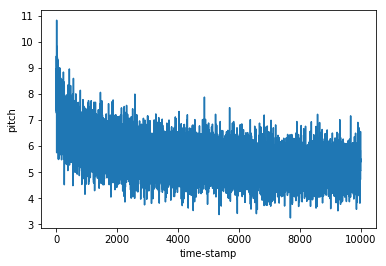

predicted accompany:


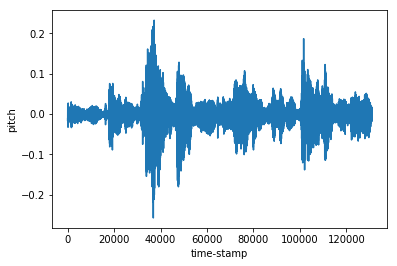

predicted vocal:


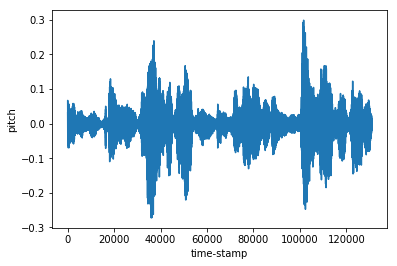

original accompany:


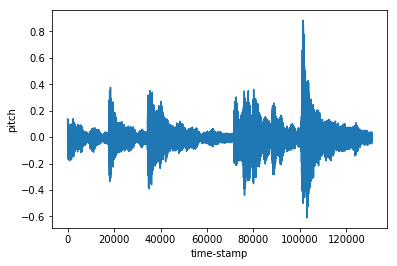

original vocal:


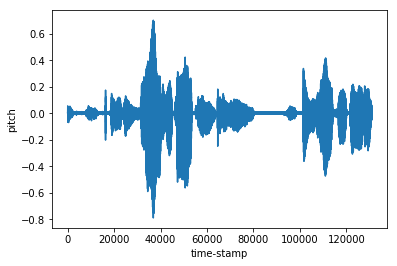

(1, 131072)
Difference:


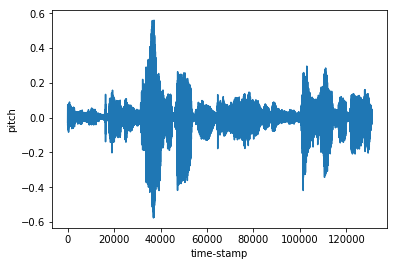

13.785836


In [5]:
import tensorflow as tf
#from model import Model
from model import Model
import os
import shutil
from data import Data
from preprocess import to_spectrogram, get_magnitude

import librosa.display


def summaries(model, loss):
    for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        print(v);
        print(loss);
        tf.summary.histogram(v.name, v)
        tf.summary.histogram('grad/' + v.name, tf.gradients(loss, v))
    tf.summary.scalar('loss', loss)
    tf.summary.histogram('x_mixed', model.x_mixed)
    tf.summary.histogram('y_src1', model.y_src1)
    tf.summary.histogram('y_src2', model.y_src1)
    return tf.summary.merge_all()

# TODO multi-gpu
def train(errorrate):
    # Model
    model = Model()
    result = [];
    # Loss, Optimizer
    global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    loss_fn = model.loss()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=TrainConfig.LR).minimize(loss_fn, global_step=global_step)#
    # Summaries
    summary_op = summaries(model, loss_fn)
    recorder = model._net();
    
    with tf.Session(config=TrainConfig.session_conf) as sess:

        # Initialized, Load state
        sess.run(tf.global_variables_initializer())
        model.load_state(sess, TrainConfig.CKPT_PATH)

        writer = tf.summary.FileWriter(TrainConfig.GRAPH_PATH, sess.graph)

        # Input source
        data = Data(TrainConfig.DATA_PATH)

        loss = Diff()
        for step in range(global_step.eval(), TrainConfig.FINAL_STEP): # changed xrange to range for py3
            mixed_wav, src1_wav, src2_wav, _ = data.next_wavs(TrainConfig.SECONDS, 10)

            mixed_spec = to_spectrogram(mixed_wav)   #先变成光谱
            mixed_mag = get_magnitude(mixed_spec)    #得到幅度

            src1_spec, src2_spec = to_spectrogram(src1_wav), to_spectrogram(src2_wav)
            src1_mag, src2_mag = get_magnitude(src1_spec), get_magnitude(src2_spec)

            src1_batch, _ = model.spec_to_batch(src1_mag)
            src2_batch, _ = model.spec_to_batch(src2_mag)
            mixed_batch, _ = model.spec_to_batch(mixed_mag)
            
            src1_batch = src1_batch;
            src2_batch = src2_batch
            mixed_batch = mixed_batch

            l, haha, summary,result1 = sess.run([loss_fn, optimizer, summary_op,recorder],
                                     feed_dict={model.x_mixed: mixed_batch, model.y_src1: src1_batch,
                                                model.y_src2: src2_batch})

            loss.update(l)
            print('step-{}\td_loss={:2.2f}\tloss={}'.format(step, loss.diff * 100, loss.value))
            #writer.add_summary(summary, global_step=step)

            # Save state
            if step % TrainConfig.CKPT_STEP == 0:
                tf.train.Saver().save(sess, TrainConfig.CKPT_PATH + '/checkpoint', global_step=step)
            #xphase = get_phase(mixed_spec);
            #seq_len = xphase.shape[-1]
            #ohno = model.batch_to_spec(result1[1], 1)[:, :, :seq_len]
            #pred_result = to_wav_from_spec(ohno)#,xphase);
            #pred_result = np.squeeze(pred_result);
            #librosa.output.write_wav('training.wav', pred_result, 16000)
            errorrate[0,step] = l#math.sqrt(abs(l/mean(sum(sum(result1[1]))+sum(sum(result1[0])))));
            print(errorrate[0,step])
            
            #test part
        data = Data(TrainConfig.DATA_PATH2)
        mixed_wav2, src1_wav2, src2_wav2, wavfiles2 = data.next_wavs(TrainConfig.SECONDS, 1)
        mixed_spec2, src1_spec2, src2_spec2 = to_spectrogram(mixed_wav2),to_spectrogram(src1_wav2), to_spectrogram(src2_wav2)
        mixed_mag2, src1_mag2, src2_mag2 = get_magnitude(mixed_spec2),get_magnitude(src1_spec2), get_magnitude(src2_spec2)
        xphase2 = get_phase(mixed_spec2);
        
        
        
        src1_batch2, _ = model.spec_to_batch(src1_mag2)
        print("src1_batch2:")
        print(src1_batch2.shape)
        src2_batch2, _ = model.spec_to_batch(src2_mag2)
        mixed_batch2, _ = model.spec_to_batch(mixed_mag2)
        
        src1_batch2 = src1_batch2
        src2_batch2 = src2_batch2
        mixed_batch2 = mixed_batch2

        l2,result12 = sess.run([loss_fn,recorder], feed_dict={model.x_mixed: mixed_batch2, model.y_src1: src1_batch2,
                                                model.y_src2: src2_batch2})

        seq_len2 = xphase2.shape[-1]
        print(result12[0].shape);
        print(result12[1].shape);
        result1part1 = result12[0]
        result1part2 = result12[1]
        print('src1_wav2')

        print(type(src1_wav2[0]))
        src1_wav2 = src1_wav2[0];
        src1_wav2 = src1_wav2[np.newaxis, :]
        src2_wav2 = src2_wav2[0]
        src2_wav2 = src2_wav2[np.newaxis, :]
        print("src1_wav2")
        print(src1_wav2.shape)
        print(min(src1_wav2.T))
        print(max(src1_wav2.T))
        print(np.mean(src1_wav2))
        print("src2_wav2")
        print(src2_wav2.shape)
        print(min(src2_wav2.T))
        print(max(src2_wav2.T))
        print(np.mean(src2_wav2))
        result1part1 = model.batch_to_spec(result1part1, 1)[:, :, :seq_len2]
        result1part2 = model.batch_to_spec(result1part2, 1)[:, :, :seq_len2]
        print("result1")
        print(result1part1.shape)
        print(min(result1part1))
        print(max(result1part1))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(result1part2))
        print(max(result1part2))
        print(np.mean(result1part2))
        #processing in time
        
        mask_src1 = soft_time_freq_mask(result1part1,result1part2)
        mask_src2 = 1.-mask_src1;
        
        result1part1 = mixed_mag2*mask_src1;
        result1part2 = mixed_mag2*mask_src2;
        
        
        pred_result2 = to_wav_from_spec(result1part2)#,xphase);
        
        
        #process the wav to detect GDMRN
        
        mixed_phase = get_phase(mixed_spec2)
        pred_src1_wav = to_wav(result1part1,mixed_phase)
        result1part1 = pred_src1_wav
        pred_src2_wav = to_wav(result1part2,mixed_phase)
        result1part2 = pred_src2_wav
        mixed_wav = mixed_wav2;
        src1_wav = src1_wav2;
        src2_wav = src2_wav2;
            
        print("result1")
        print(result1part1.shape)
        print(min(abs(result1part1.T)))
        print(max(result1part1.T))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(abs(result1part2.T)))
        print(max(result1part2.T))
        print(np.mean(result1part2))
         
            
        for i in range(0,131072):
            if src1_wav[0,i] ==0:
                src1_wav[0,i] = src1_wav[0,i]+0.01
            if src2_wav[0,i] ==0:
                src2_wav[0,i] = src2_wav[0,i]+0.01
            if pred_src1_wav[0,i] ==0:
                pred_src1_wav[0,i] = pred_src1_wav[0,i]+0.01
            if pred_src2_wav[0,i] ==0:
                pred_src2_wav[0,i] = pred_src2_wav[0,i]+0.01
       
        
        #存成文件
        john = np.savetxt('errorrate.csv', errorrate.T, delimiter = ',')
        print(errorrate.shape)
        print(errorrate[0])
        plt.figure()
        plt.plot(errorrate[0])
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_predicted.wav', pred_src1_wav.T, 16000)
        plt.figure()
        print('predicted accompany:')
        plt.plot( pred_src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_predicted2.wav', pred_src2_wav.T, 16000)
        plt.figure()
        print('predicted vocal:')
        plt.plot(pred_src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_original1.wav',src1_wav.T, 16000)
        plt.figure()
        print('original accompany:')
        plt.plot( src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_original2.wav',src2_wav.T, 16000)
        plt.figure()
        print('original vocal:')
        plt.plot(src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        difference = src2_wav-pred_src2_wav;
        print(difference.shape)
        john = librosa.output.write_wav('lstm_difference.wav',difference.T, 16000)
        plt.figure()
        print('Difference:')
        plt.plot(difference.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        print(np.mean(difference)/np.mean(src2_wav))
        


        
        writer.close()

def setup_path():
    if TrainConfig.RE_TRAIN:
        if os.path.exists(TrainConfig.CKPT_PATH):
            shutil.rmtree(TrainConfig.CKPT_PATH)
        if os.path.exists(TrainConfig.GRAPH_PATH):
            shutil.rmtree(TrainConfig.GRAPH_PATH)
    if not os.path.exists(TrainConfig.CKPT_PATH):
        os.makedirs(TrainConfig.CKPT_PATH)


if __name__ == '__main__':
    errorrate = np.zeros([2,TrainConfig.FINAL_STEP]);
    setup_path()
    train(errorrate)


In [ ]:
import soundfile
import matplotlib.pyplot as plt
my_matrix = np.loadtxt(open('originhuman.csv',"rb"),delimiter=",",skiprows=0)
my_matrix2 = np.loadtxt(open('generatedhuman.csv',"rb"),delimiter=",",skiprows=0)
print(my_matrix)
print(my_matrix2)
print(type(my_matrix))
print(type(my_matrix2))
print(my_matrix.shape)
print(my_matrix2.shape)

diff = abs(my_matrix2)-abs(my_matrix)
print(diff)
print(np.mean(diff))
print(np.max(diff))
print(np.min(diff))
print(np.var(diff))
plt.plot(my_matrix)
plt.xlabel('time-stamp')
plt.ylabel('pitch')
soundfile.write('lstm1.wav', my_matrix, 16000)
soundfile.write('lstm2.wav', my_matrix2, 16000)

Text(0, 0.5, 'errorrate')

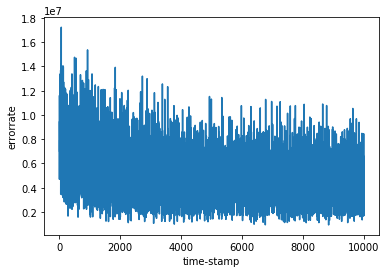

In [7]:
my_matrix = np.loadtxt(open('errorrate.csv',"rb"),delimiter=",",skiprows=0)
plt.plot(my_matrix[0])
plt.xlabel('time-stamp')
plt.ylabel('errorrate')

In [3]:
haha0 = librosa.load('dataset/train/ikala/abjones_1_03.wav', sr = 16000, mono=False)
print('direct loaded data:')
print(haha0)
print(np.mean(haha0[0][1]))
print(np.max(haha0[0][1]))
print(np.min(haha0[0][1]))
haha = _pad_wav(librosa.load('dataset/train/ikala/abjones_1_03.wav', sr = 16000, mono=False)[0],16000,8.192)
print(haha.shape)
haha = to_spectrogram(haha);
print('In spectrum form:')
print(haha.shape)
temp = np.squeeze(haha[1])

print(temp)
print(np.mean(sum(sum(temp))))
print(np.max(temp))
print(np.min(temp))

#提取了1维的内容
haha = haha[1,:,:]
haha = haha[np.newaxis,:,:]
haha = to_wav_from_spec(haha)
print(haha)
print(np.mean(haha0[0][1]))
print(np.max(haha0[0][1]))
print(np.min(haha0[0][1]))
haha = np.squeeze(haha)
print('difference between replaced and original sound')
haha = haha0[0][1]-haha[0:114177]
print(haha)
print(np.mean(haha0[0][1]))
print(np.max(haha0[0][1]))
print(np.min(haha0[0][1]))
librosa.output.write_wav('testing.wav', haha, 22050)

direct loaded data:
(array([[-0.01565552, -0.01461792, -0.01071167, ...,  0.00323486,
        -0.00027466, -0.00140381],
       [ 0.00033569,  0.        , -0.00048828, ...,  0.00048828,
        -0.00204468, -0.00253296]], dtype=float32), 16000)
0.00011409352
0.4961853
-0.44973755
(2, 131072)
In spectrum form:
(2, 513, 513)
[[-4.7116694e-01+0.0000000e+00j -4.6395144e-01+0.0000000e+00j
  -6.5111274e-01+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 2.1697406e-01+9.7578196e-19j  2.2411314e-01+1.9295413e-02j
   2.9057652e-01-2.0339881e-01j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 1.0903644e-01+3.4152368e-18j -8.4128462e-02-1.1404621e-01j
   8.6127743e-02+2.4426898e-01j ...  0.0000000e+00-0.0000000e+00j
   0.0000000e+00-0.0000000e+00j  0.0000000e+00-0.0000000e+00j]
 ...
 [-5.3930178e-04-3.4152368e-18j  3.1252170e-04+6.3582446e-04j
  -1.8401776e-04-2.8828124e-04j ...

In [6]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
